In [1]:
import os
import cv2
from PIL import Image
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
#from torch.optim.lr_scheduler import _LRScheduler

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision import models
from torchsummary import summary
import torch.nn.functional as F
import random

/home/MMI24limbyungwan/.conda/envs/byungwan_resn/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# GPU 사용이 가능할 경우, GPU를 사용할 수 있게 함.'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

print(os.environ.get('CUDA_VISIBLE_DEVICES'))

cuda
3


In [3]:
# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# 클래스별 IoU를 계산하기 위한 함수
def calculate_iou_per_class(y_true, y_pred, class_id):
    intersection = np.sum((y_true == class_id) & (y_pred == class_id))
    union = np.sum((y_true == class_id) | (y_pred == class_id))
    iou = intersection / union if union > 0 else 0
    return iou

def normalize_image(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # 이미지를 0과 1 사이의 값으로 스케일 조정
    #image = image.to(torch.float)
    normalized_image = image / 255.0
    normalized_image = (normalized_image - mean) / std

    return normalized_image


In [4]:
# background = cv2.imread('./background.png')
# image = cv2.imread('./data/224/train_source_image/TRAIN_SOURCE_0000.png')
# print(image.ndim)
# h,w,_ = image.shape
# background = cv2.resize(background, (h,w))
# background_mask = background[:,:,0]

In [5]:
def make_bumper(image, mask):
    h,w,c = image.shape
    center = (w//2, int(h*0.375))  # x,y
    axis_length = (w//2, int(h*0.64))  # 장축 반지름과 단축 반지름

    # 타원 그리기 (타원을 1로 채우고 나머지 부분은 0으로 채움)
    oval = np.zeros((h,w,1),dtype=np.uint8)
    cv2.ellipse(oval, center, axis_length, 0, 0, 360, 1, -1)

    num_bumper = random.randint(0,2922)
    target_image_path = (f'./data/224/train_target_image/TRAIN_TARGET_{num_bumper:04d}.png')
    #target_image_path = './data/224/train_target_image/TRAIN_TARGET_0001.png'
    target_image = cv2.imread(target_image_path, cv2.IMREAD_COLOR)
    target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)
    target_image = cv2.resize(target_image, (448,448))
    target_image = normalize_image(target_image)

    mixed_image = image * oval + target_image * (1-oval)
    mixed_mask = mask * oval[:,:,0] + np.ones_like(mask)*0*(1-oval[:,:,0])

    return mixed_image, mixed_mask



In [6]:
def make_bumper_std(image, mask):
    h,w,_ = image.shape
    background = cv2.imread('./background.png')
    background = cv2.resize(background, (h,w))
    background_mask = background[:,:,0]

    target_image = cv2.imread('./data/224/target_val_image/svm_front_2021-06-04-14-37-37_00000000.png')
    target_image = normalize_image(target_image)

    target_image = cv2.resize(target_image, (h,w))
    
    bumper_image = image * background + target_image * (1-background)
    bumper_mask = mask * background_mask + np.ones_like(mask)*0*(1-background_mask)

    
    return bumper_image, bumper_mask

In [7]:
import numpy as np
import cv2
import torch

def apply_fisheye_distortion(images, masks, label):
    # 이미지 크기 가져오기
    batch, channel, height, width = images.shape

    # 카메라 매트릭스 생성
    focal_length = width / 2
    center_x = width / 2
    center_y = height / 2
    camera_matrix = np.array([[focal_length, 0, center_x],
                              [0, focal_length, center_y],
                              [0, 0, 1]], dtype=np.float32)

    # 왜곡 계수 생성
    # dist_num = 0
    # if label == 1:
    #     dist_num = random.randint(1,3)
    # elif label == 2.5:
    #     dist_num = 2.5
    if label == 5:
        dist_num = 0
    else:
        dist_num = 2**(label)
    dist_coeffs = np.array([0, 0.03 * dist_num, 0, 0], dtype=np.float32)

    # 왜곡 보정
    undistorted_images = []
    undistorted_masks = []

    road_k = 0.4

    for i in range(batch):
        image = images[i].permute(1, 2, 0).cpu().numpy()  # 텐서를 NumPy 배열로 변환
        mask = masks[i].cpu().numpy()
        undistorted_image = cv2.undistort(image, camera_matrix, dist_coeffs)
        undistorted_mask = cv2.undistort(mask, camera_matrix, dist_coeffs)

        if label != 5:
            undistorted_image = cv2.resize(undistorted_image[int(height*road_k):int(height*0.8),:], (height, width))
            undistorted_mask = cv2.resize(undistorted_mask[int(height*road_k):int(height*0.8),:], (height, width))

        undistorted_mask = np.round(undistorted_mask).astype(np.uint8)
        undistorted_mask[undistorted_mask > 12] = 12

        undistorted_image = normalize_image(undistorted_image)
        #undistorted_mask = normalize_image(undistorted_mask)
        if label != 5:
            undistorted_image, undistorted_mask = make_bumper(undistorted_image, undistorted_mask)

        #다시 텐서로 변환
        undistorted_image = torch.from_numpy(undistorted_image).permute(2, 0, 1).float().to(device)
        undistorted_mask = torch.from_numpy(undistorted_mask).long().to(device)

        undistorted_images.append(undistorted_image)
        undistorted_masks.append(undistorted_mask)

    undistorted_images = torch.stack(undistorted_images, dim=0)
    undistorted_masks = torch.stack(undistorted_masks, dim=0)

    return undistorted_images, undistorted_masks


In [8]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False, CL=0):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer
        self.CL = CL

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #directory_path = "/mnt/nas27/Dataset/Samsung_DM"
        directory_path = './data/448'
        img_path = self.data.iloc[idx, 1]
        img_path = os.path.join(directory_path, img_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image
        
        mask_path = self.data.iloc[idx, 2]
        mask_path = os.path.join(directory_path, mask_path)
        mask = cv2.imread(mask_path)
        #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        if self.CL == 0:
            mask = np.round(mask).astype(np.uint8)
            mask[mask > 12] = 12 #배경을 픽셀값 12로 간주
            mask += 1
            mask[mask == 13] = 0

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask
     

transform = A.Compose(
    [   
        #A.Resize(224, 224),
        #A.Resize(128, 128),
        #A.Normalize(),
        #A.GaussNoise(var_limit=(10.0, 30.0), p=0.3),
        
        # 변형
        A.HorizontalFlip(p=0.5),
        # A.RandomRotate90(p=0.5),
        # A.HueSaturationValue(p=0.2),
        A.ColorJitter(brightness=0.7, contrast=0.7, saturation=0.7),
        
        ToTensorV2()
    ]
)

totensor = A.Compose(
    [   
        #A.Resize(224, 224),
        #A.Resize(128, 128),
        #A.Normalize(),
        #A.GaussNoise(var_limit=(10.0, 30.0), p=0.3),
        
        # 변형
        #A.HorizontalFlip(p=0.5),
        # A.RandomRotate90(p=0.5),
        # A.HueSaturationValue(p=0.2),
        #A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        
        ToTensorV2()
    ]
)

## 기본 U-Net

In [9]:
#Unet의 기본이 되는 conv블럭
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)  # 여기서 in_channels는 out_channels와 동일해야 합니다.
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

#인코더 블럭
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock,self).__init__()
        self.convblock1 = ConvBlock(in_channels, out_channels)  # 첫 번째 ConvBlock의 in_channels는 입력 이미지의 채널 수와 일치해야 합니다.
        #self.convblock2 = ConvBlock(out_channels, out_channels)  # 두 번째 ConvBlock의 in_channels는 out_channels와 일치해야 합니다.
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self,x):
        x = self.convblock1(x)
        #x = self.convblock2(x)
        p = self.maxpool(x)
        return x , p
#디코더 블럭
#디코더는 업샘플링 이후 스킵연결과 붙어서 convblock을 통과해야함
#skip보다 작은 x x먼저 업샘플링 32 -> 64 , skip과 결합 6464 
class DecoderBlock(nn.Module):
    def __init__(self, channels):
        super(DecoderBlock,self).__init__()
        self.upsample = nn.ConvTranspose2d(channels*2, channels, kernel_size=4, stride=2, padding=1)#x 업샘플링
        self.convblock1 = ConvBlock(channels*2, channels)#차원감소
        #self.convblock2 = ConvBlock(channels, channels)
    def forward(self,x,skip):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        x = self.convblock1(x)
        #x = self.convblock2(x)
        return x

###########################################
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(self, x):
        return x.view_as(x)
    @staticmethod
    def backward(self, grad_output): # 역전파 시에 gradient에 음수를 취함
        return (grad_output * -1)

class domain_classifier(nn.Module):
    def __init__(self):
        super(domain_classifier, self).__init__()
        self.conv1 = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        self.fc1 = nn.Linear(448*448*1, 10)
        self.fc2 = nn.Linear(10, 3) # source = 0, target = 1 회귀 가정
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = GradReverse.apply(x) # gradient reverse
        x = self.conv1(x)
        x = x.view(-1, 448*448*1)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

###########################################


#Unet구조 middle의 xm값의 움직임에 주의
class Unet(nn.Module):
    def __init__(self,n_classes):
        super(Unet,self).__init__()
        self.encoder1 = EncoderBlock(3,64)
        self.encoder2 = EncoderBlock(64,128)
        self.encoder3 = EncoderBlock(128,256)
        self.encoder4 = EncoderBlock(256,512)
        
        self.middleconv = ConvBlock(512,1024)
        
        
        self.decoder4 = DecoderBlock(512)
        self.decoder3 = DecoderBlock(256)
        self.decoder2 = DecoderBlock(128)
        self.decoder1 = DecoderBlock(64)
        self.segmap = nn.Conv2d(64,n_classes, kernel_size=1)
        
        self.domain_classifier = domain_classifier()
                                        

    def forward(self,x):
        x1,p = self.encoder1(x)#3->64   #P:256,256 x1 :512,512
        x2,p = self.encoder2(p)#64->128 #P:128,128 x2:256,256
        x3,p = self.encoder3(p)#128->256#p:64,64 x3:128,128
        x4,p = self.encoder4(p)#256->512#p:32,32 x4:64,64
        
        xm = self.middleconv(p)#512->1024#32,32
        
        x = self.decoder4(xm,x4)#뉴런:1024->512->512 #출력tensor:64,64
        x = self.decoder3(x,x3)#뉴런:512->256->256 #출력tensor:128,128
        x = self.decoder2(x,x2)#뉴런:256->128->128 #출력tensor:256,256
        x = self.decoder1(x,x1)#뉴런:128->64->64 #출력tensor:512,512

        x_c = self.segmap(x)
        x_d = self.domain_classifier(x)
        # print("x_c", x_c.shape)
        # print("x_d", x_d.shape)
        return x_c, x_d

## Resnet50

In [10]:
# class GradReverse(torch.autograd.Function):
#     @staticmethod
#     def forward(self, x):
#         return x.view_as(x)
#     @staticmethod
#     def backward(self, grad_output): # 역전파 시에 gradient에 음수를 취함
#         return grad_output * (-1)

# class domain_classifier(nn.Module):
#     def __init__(self):
#         super(domain_classifier, self).__init__()
#         self.conv1 = nn.Conv2d(128, 1, kernel_size=1)
#         self.fc1 = nn.Linear(224*224*1, 10)
#         self.fc2 = nn.Linear(10, 4) # source = 0, target = 1 회귀 가정

#     def forward(self, x):
#         x = self.conv1(x)
#         x = x.view(-1, 224*224*1)
#         #print(x.shape)
#         x = GradReverse.apply(x) # gradient reverse
#         x = F.leaky_relu(self.fc1(x))
#         x = self.fc2(x)
#         #print(x.shape)
#         #return torch.sigmoid(x)
#         return x

# #Unet의 기본이 되는 conv블럭
# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels,kernel_size = 3):
#         super(ConvBlock, self).__init__()
#         self.kernel_size = kernel_size
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.relu1 = nn.ReLU()
        
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1)  # 여기서 in_channels는 out_channels와 동일해야 합니다.
#         self.bn2 = nn.BatchNorm2d(out_channels)
#         self.relu2 = nn.ReLU()

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu1(x)
        
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu2(x)
#         return x
# class IdentityBlock(nn.Module):
#     def __init__(self, in_channels, mid_channels, out_channels, stride=1):
#         super(IdentityBlock, self).__init__()
        
#         # 1x1 convolution
#         self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=stride, bias=False)
#         self.bn1 = nn.BatchNorm2d(mid_channels)
#         self.relu1 = nn.ReLU()

#         # 3x3 convolution
#         self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(mid_channels)
#         self.relu2 = nn.ReLU()

#         # 1x1 convolution
#         self.conv3 = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
#         self.bn3 = nn.BatchNorm2d(out_channels)
#         self.relu3 = nn.ReLU()
        
#     def forward(self, x):
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu1(out)
        
#         out = self.conv2(out)
#         out = self.bn2(out)
#         out = self.relu2(out)
         
#         out = self.conv3(out)
#         out = self.bn3(out)
#         out = self.relu3(out)
        
#         return out
# class HeadBlock(IdentityBlock):
#     def __init__(self, in_channels, mid_channels, out_channels, stride=1):
#         super(HeadBlock, self).__init__(in_channels, mid_channels, out_channels, stride)
        
#         self.shortcut = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
#             nn.BatchNorm2d(out_channels)
#         )

#     def forward(self, x):
#         identity = x
#         out = super().forward(x)
        
#         if identity.size() != out.size():
#             identity = F.interpolate(identity, size=out.size()[2:])
#         identity = self.shortcut(identity)
        
#         out += identity
#         out = self.relu3(out)
        
#         return out
# #인코더 블럭
# class Conv2(nn.Module):
#     def __init__(self,in_channels, mid_channels, out_channels):
#         super(Conv2,self).__init__() 
#         self.headblock = HeadBlock(in_channels,mid_channels,out_channels)
#         self.identityblock1 = IdentityBlock(out_channels,mid_channels,out_channels)
#         self.identityblock2 = IdentityBlock(out_channels,mid_channels,out_channels)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
#     def forward(self,x):
#         x = self.headblock(x)
#         x = self.identityblock1(x)
#         x = self.identityblock2(x)
#         p = self.maxpool(x)
#         return x , p
# class Conv3(nn.Module):
#     def __init__(self,in_channels, mid_channels, out_channels):
#         super(Conv3,self).__init__() 
#         self.headblock = HeadBlock(in_channels,mid_channels,out_channels)
#         self.identityblock1 = IdentityBlock(out_channels,mid_channels,out_channels)
#         self.identityblock2 = IdentityBlock(out_channels,mid_channels,out_channels)
#         self.identityblock3 = IdentityBlock(out_channels,mid_channels,out_channels)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
#     def forward(self,x):
#         x = self.headblock(x)
#         x = self.identityblock1(x)
#         x = self.identityblock2(x)
#         x = self.identityblock3(x)
#         p = self.maxpool(x)
#         return x , p
# class Conv4(nn.Module):
#     def __init__(self,in_channels, mid_channels, out_channels):
#         super(Conv4,self).__init__() 
#         self.headblock = HeadBlock(in_channels,mid_channels,out_channels)
#         self.identityblock1 = IdentityBlock(out_channels,mid_channels,out_channels)
#         self.identityblock2 = IdentityBlock(out_channels,mid_channels,out_channels)
#         self.identityblock3 = IdentityBlock(out_channels,mid_channels,out_channels)
#         self.identityblock4 = IdentityBlock(out_channels,mid_channels,out_channels)
#         self.identityblock5 = IdentityBlock(out_channels,mid_channels,out_channels)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
#     def forward(self,x):
#         x = self.headblock(x)
#         x = self.identityblock1(x)
#         x = self.identityblock2(x)
#         x = self.identityblock3(x)
#         x = self.identityblock4(x)
#         x = self.identityblock5(x)
#         p = self.maxpool(x)
#         return x , p
# class Conv5(nn.Module):
#     def __init__(self,in_channels, mid_channels, out_channels):
#         super(Conv5,self).__init__() 
#         self.headblock = HeadBlock(in_channels,mid_channels,out_channels)
#         self.identityblock1 = IdentityBlock(out_channels,mid_channels,out_channels)
#         self.identityblock2 = IdentityBlock(out_channels,mid_channels,out_channels)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
#     def forward(self,x):
#         x = self.headblock(x)
#         x = self.identityblock1(x)
#         x = self.identityblock2(x)
#         p = self.maxpool(x)
#         return x , p
# #디코더 블럭
# class DecoderBlock(nn.Module):
#     def __init__(self, channels):
#         super(DecoderBlock, self).__init__()
#         self.upsample = nn.ConvTranspose2d(channels*2, channels, kernel_size=4, stride=2, padding=1, output_padding=1) # output_padding 추가
#         self.convblock1 = ConvBlock(channels*2, channels)

#     def forward(self, x, skip):
#         x = self.upsample(x)
#         if x.size(2) != skip.size(2) or x.size(3) != skip.size(3):
#             x = F.interpolate(x, size=(skip.size(2), skip.size(3)))
#         x = torch.cat([x, skip], dim=1)
#         x = self.convblock1(x)
#         return x

# #Unet구조 middle의 xm값의 움직임에 주의
# class Resnet50_Unet(nn.Module):
#     def __init__(self,n_classes):
#         super(Resnet50_Unet,self).__init__()
#         self.fconv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2)
#         self.fbn1 = nn.BatchNorm2d(64)
#         self.frelu1 = nn.ReLU()
#         self.fconv2 = nn.Conv2d(64, 128, kernel_size=1, stride=1)
#         self.fbn2 = nn.BatchNorm2d(128)
#         self.frelu2 = nn.ReLU()
#         self.fmaxpooling = nn.MaxPool2d(kernel_size=3,stride=2)
        
#         self.conv2 = Conv2(128,64,256)
#         self.conv3 = Conv3(256,128,512)
#         self.conv4 = Conv4(512,256,1024)
#         self.conv5 = Conv5(1024,512,2048)
        
#         self.middleconv = ConvBlock(2048,4096)
#         self.dropout = nn.Dropout2d(0.4) #
           
#         self.decoder5 = DecoderBlock(2048)
#         self.decoder4 = DecoderBlock(1024)
#         self.decoder3 = DecoderBlock(512)
#         self.decoder2 = DecoderBlock(256)
#         self.decoder1 = DecoderBlock(128)
        
#         self.segmap = nn.Conv2d(128,n_classes, kernel_size=1)
#         self.domain_classifier = domain_classifier()
        
#     def forward(self,x):
#         x = self.fconv1(x)#3->64
#         x = self.fbn1(x)
#         x = self.frelu1(x)
#         x = self.fconv2(x)
#         x = self.fbn2(x)
#         x1 = self.frelu2(x)
#         p = self.fmaxpooling(x)#첫 conv: x0([8, 64, 109, 109]) p([8, 64, 54, 54])
#         x2,p = self.conv2(p)#conv2:  x1:([8, 256, 54, 54]) p([8, 256, 26, 26])
#         x3,p = self.conv3(p)#conv3:  x2([8, 512, 26, 26]) p([8, 512, 12, 12])
#         x4,p = self.conv4(p)#conv4:  x3([8, 1024, 12, 12]) p([8, 1024, 5, 5])
#         x5,p = self.conv5(p)#conv5:  x4([8, 2048, 5, 5]) p([8, 2048, 2, 2])
        
#         xm = self.middleconv(p)#xm([8, 4096, 2, 2])
#         xm = self.dropout(xm)
        
#         x = self.decoder5(xm,x5)#뉴런:2048*2->2048 1
#         x = self.decoder4(x,x4)#뉴런:1024*2->1024 
#         x = self.decoder3(x,x3) #14
#         x = self.decoder2(x,x2)#28
#         x = self.decoder1(x,x1)#55
        
#         x = F.interpolate(x, size=(224, 224))
#         x_c = self.segmap(x)
#         x_d = self.domain_classifier(x)
#         #print(x.shape)
#         return x_c,x_d

## Resnet34

In [11]:
# class GradReverse(torch.autograd.Function):
#     @staticmethod
#     def forward(self, x):
#         return x.view_as(x)
#     @staticmethod
#     def backward(self, grad_output): # 역전파 시에 gradient에 음수를 취함
#         return grad_output * (-1)

# class domain_classifier(nn.Module):
#     def __init__(self):
#         super(domain_classifier, self).__init__()
#         self.fc1 = nn.Linear(224*224*64, 50)
#         self.fc2 = nn.Linear(50, 3) # source = 0, target = 1 회귀 가정
#         ##
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x):
#         x = x.view(-1, 224*224*64)
#         x = GradReverse.apply(x) # gradient reverse
#         x = F.leaky_relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
        
#         #return torch.sigmoid(x)
#         return x

# class domain_linear(nn.Module):
#     def __init__(self):
#         super(domain_linear, self).__init__()
#         self.fc1 = nn.Linear(224*224*64, 10)
#         self.fc2 = nn.Linear(10, 1) # source = 0, target = 1 회귀 가정

#     def forward(self, x):
#         x = x.view(-1, 224*224*64)
#         x = GradReverse.apply(x) # gradient reverse
#         x = F.leaky_relu(self.fc1(x))
#         x = self.fc2(x)
        
#         return torch.sigmoid(x)
#         #return x
# class IdentityBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1):
#         super(IdentityBlock, self).__init__()
        
#         # 3x3 convolution
#         self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, stride=stride, bias=False)
#         self.bn1 = nn.BatchNorm2d(in_channels)
#         self.relu1 = nn.ReLU()
        
#         # 3x3 convolution
#         self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(out_channels)
#         self.relu2 = nn.ReLU()
        
#         # Skip connection
#         self.skip = nn.Sequential()
#         if stride != 1 or in_channels != out_channels:
#             self.skip = nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(out_channels)
#             )
        
#     def forward(self, x):
#         identity = x
        
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu1(out)
        
#         out = self.conv2(out)
#         out = self.bn2(out)
        
#         # Adding the skip connection
#         out += self.skip(identity)
#         out = self.relu2(out)
        
#         return out
# #인코더 블럭
# class Conv2(nn.Module):
#     def __init__(self,in_channels, out_channels):
#         super(Conv2,self).__init__() 
#         self.identityblock1 = IdentityBlock(in_channels,in_channels)
#         self.identityblock2 = IdentityBlock(in_channels,in_channels)
#         self.identityblock3 = IdentityBlock(in_channels,out_channels)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
#     def forward(self,x):
#         x = self.identityblock1(x)
#         x = self.identityblock2(x)
#         x = self.identityblock3(x)
#         p = self.maxpool(x)
        
#         return x , p
# class Conv3(nn.Module):
#     def __init__(self,in_channels, out_channels):
#         super(Conv3,self).__init__()         
#         self.identityblock1 = IdentityBlock(in_channels,in_channels)
#         self.identityblock2 = IdentityBlock(in_channels,in_channels)
#         self.identityblock3 = IdentityBlock(in_channels,in_channels)
#         self.identityblock4 = IdentityBlock(in_channels,out_channels)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
#     def forward(self,x):
#         x = self.identityblock1(x)
#         x = self.identityblock2(x)
#         x = self.identityblock3(x)
#         x = self.identityblock4(x)
#         p = self.maxpool(x)
        
#         return x , p
# class Conv4(nn.Module):
#     def __init__(self,in_channels, out_channels):
#         super(Conv4,self).__init__()         
#         self.identityblock1 = IdentityBlock(in_channels,in_channels)
#         self.identityblock2 = IdentityBlock(in_channels,in_channels)
#         self.identityblock3 = IdentityBlock(in_channels,in_channels)
#         self.identityblock4 = IdentityBlock(in_channels,in_channels)
#         self.identityblock5 = IdentityBlock(in_channels,in_channels)
#         self.identityblock6 = IdentityBlock(in_channels,out_channels)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
#     def forward(self,x):
#         x = self.identityblock1(x)
#         x = self.identityblock2(x)
#         x = self.identityblock3(x)
#         x = self.identityblock4(x)
#         x = self.identityblock5(x)
#         x = self.identityblock6(x)
#         p = self.maxpool(x)
        
#         return x , p
# class Conv5(nn.Module):
#     def __init__(self,in_channels, out_channels):
#         super(Conv5,self).__init__() 
#         self.identityblock1 = IdentityBlock(in_channels,in_channels)
#         self.identityblock2 = IdentityBlock(in_channels,in_channels)
#         self.identityblock3 = IdentityBlock(in_channels,out_channels)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
        
#     def forward(self,x):
#         x = self.identityblock1(x)
#         x = self.identityblock2(x)
#         x = self.identityblock3(x)
#         p = self.maxpool(x)
        
#         return x , p
# #디코더 블럭
# class DecoderBlock(nn.Module):
#     def __init__(self, channels):
#         super(DecoderBlock, self).__init__()
#         self.upsample = nn.ConvTranspose2d(channels*2, channels, kernel_size=4, stride=2, padding=1) # output_padding 추가
#         self.convblock1 = IdentityBlock(channels*2, channels)

#     def forward(self, x, skip):
#         x = self.upsample(x)
#         if x.size(2) != skip.size(2) or x.size(3) != skip.size(3):
#             x = F.interpolate(x, size=(skip.size(2), skip.size(3)))
#         x = torch.cat([x, skip], dim=1)
#         x = self.convblock1(x)
#         #print("x",x.shape,"skip: ",skip.shape)
#         return x

# #Unet구조 middle의 xm값의 움직임에 주의
# class Resnet34_Unet(nn.Module):
#     def __init__(self,n_classes):
#         super(Resnet34_Unet,self).__init__()
#         self.fconv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
#         self.fbn1 = nn.BatchNorm2d(64)
#         self.frelu1 = nn.ReLU()
#         self.fmaxpooling = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        
#         self.conv2 = Conv2(64,128)
#         self.conv3 = Conv3(128,256)
#         self.conv4 = Conv4(256,512)
#         self.conv5 = Conv5(512,1024)
        
#         self.middleconv = IdentityBlock(1024,2048)
#         self.dropout = nn.Dropout2d(0.1) #
           
#         self.decoder5 = DecoderBlock(1024)
#         self.decoder4 = DecoderBlock(512)
#         self.decoder3 = DecoderBlock(256)
#         self.decoder2 = DecoderBlock(128)
#         self.decoder1 = DecoderBlock(64)
#         self.transpose = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1) # output_padding 추가
        
#         self.segmap = nn.Conv2d(64,n_classes, kernel_size=1)
#         self.domain_classifier = domain_classifier()
#         self.domain_linear = domain_linear()
        
#     def forward(self,x):
#         x = self.fconv1(x)#3->64
#         x0 = self.fbn1(x)
#         x1 = self.frelu1(x)
#         p = self.fmaxpooling(x1)#첫 conv: x0([8, 64, 109, 109]) p([8, 64, 54, 54])
#         #print("conv1: ",x1.shape, "maxpooling: ",p.shape)
#         x2,p = self.conv2(p)
#         #print("conv2: ",x2.shape, "maxpooling: ",p.shape)
#         x3,p = self.conv3(p)
#         #print("conv3: ",x3.shape, "maxpooling: ",p.shape)
#         x4,p = self.conv4(p)
#         #print("conv4: ",x4.shape, "maxpooling: ",p.shape)
#         x5,p = self.conv5(p)
#         #print("conv5: ",x5.shape, "maxpooling: ",p.shape)
        
#         xm = self.middleconv(p)#xm([8, 4096, 2, 2])
#         #print("xm: ",xm.shape, "maxpooling: ",p.shape)
#         #xm = self.dropout(xm)
        
#         x = self.decoder5(xm,x5)#뉴런:2048*2->2048 1
#         x = self.decoder4(x,x4)#뉴런:1024*2->1024 
#         x = self.decoder3(x,x3) #14
#         x = self.decoder2(x,x2)#28
#         x = self.decoder1(x,x1)#55
#         x = self.transpose(x)
        
#         #print(x.shape)
#         #x = F.interpolate(x, size=(224, 224))
#         x_c = self.segmap(x)
#         #x_d = self.domain_linear(x)
#         x_d = self.domain_classifier(x)
        
        
#         return x_c,x_d

## Resnet18

In [12]:
# class GradReverse(torch.autograd.Function):
#     @staticmethod
#     def forward(self, x):
#         return x.view_as(x)
#     @staticmethod
#     def backward(self, grad_output): # 역전파 시에 gradient에 음수를 취함
#         return grad_output * (-1)

# class domain_classifier(nn.Module):
#     def __init__(self):
#         super(domain_classifier, self).__init__()
#         self.fc1 = nn.Linear(224*224*64, 10)
#         self.fc2 = nn.Linear(10, 4) # source = 0, target = 1 회귀 가정

#     def forward(self, x):
#         x = x.view(-1, 224*224*64)
#         x = GradReverse.apply(x) # gradient reverse
#         x = F.leaky_relu(self.fc1(x))
#         x = self.fc2(x)
        
#         #return torch.sigmoid(x)
#         return x

# class IdentityBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1):
#         super(IdentityBlock, self).__init__()
        
#         # 3x3 convolution
#         self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, stride=stride, bias=False)
#         self.bn1 = nn.BatchNorm2d(in_channels)
#         self.relu1 = nn.ReLU()
        
#         # 3x3 convolution
#         self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(out_channels)
#         self.relu2 = nn.ReLU()
        
#         # Skip connection
#         self.skip = nn.Sequential()
#         if stride != 1 or in_channels != out_channels:
#             self.skip = nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(out_channels)
#             )
        
#     def forward(self, x):
#         identity = x
        
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu1(out)
        
#         out = self.conv2(out)
#         out = self.bn2(out)
        
#         # Adding the skip connection
#         out += self.skip(identity)
#         out = self.relu2(out)
        
#         return out


# #인코더 블럭
# class Conv2(nn.Module):
#     def __init__(self,in_channels, out_channels):
#         super(Conv2,self).__init__() 
#         self.identityblock1 = IdentityBlock(in_channels,in_channels)
#         self.identityblock2 = IdentityBlock(in_channels,out_channels)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
#     def forward(self,x):
#         x = self.identityblock1(x)
#         x = self.identityblock2(x)
#         p = self.maxpool(x)
        
#         return x , p
# class Conv3(nn.Module):
#     def __init__(self,in_channels, out_channels):
#         super(Conv3,self).__init__()         
#         self.identityblock1 = IdentityBlock(in_channels,in_channels)
#         self.identityblock2 = IdentityBlock(in_channels,out_channels)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
#     def forward(self,x):
#         x = self.identityblock1(x)
#         x = self.identityblock2(x)
#         p = self.maxpool(x)
        
#         return x , p
# class Conv4(nn.Module):
#     def __init__(self,in_channels, out_channels):
#         super(Conv4,self).__init__()         
#         self.identityblock1 = IdentityBlock(in_channels,in_channels)
#         self.identityblock2 = IdentityBlock(in_channels,out_channels)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
#     def forward(self,x):
#         x = self.identityblock1(x)
#         x = self.identityblock2(x)
#         p = self.maxpool(x)
        
#         return x , p
# class Conv5(nn.Module):
#     def __init__(self,in_channels, out_channels):
#         super(Conv5,self).__init__() 
#         self.identityblock1 = IdentityBlock(in_channels,in_channels)
#         self.identityblock2 = IdentityBlock(in_channels,out_channels)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
        
#     def forward(self,x):
#         x = self.identityblock1(x)
#         x = self.identityblock2(x)
#         p = self.maxpool(x)
        
#         return x , p
# #디코더 블럭
# class DecoderBlock(nn.Module):
#     def __init__(self, channels):
#         super(DecoderBlock, self).__init__()
#         self.upsample = nn.ConvTranspose2d(channels*2, channels, kernel_size=4, stride=2, padding=1) # output_padding 추가
#         self.convblock1 = IdentityBlock(channels*2, channels)

#     def forward(self, x, skip):
#         x = self.upsample(x)
#         if x.size(2) != skip.size(2) or x.size(3) != skip.size(3):
#             x = F.interpolate(x, size=(skip.size(2), skip.size(3)))
#         x = torch.cat([x, skip], dim=1)
#         x = self.convblock1(x)
#         #print("x",x.shape,"skip: ",skip.shape)
#         return x

# #Unet구조 middle의 xm값의 움직임에 주의
# class Resnet18_Unet(nn.Module):
#     def __init__(self,n_classes):
#         super(Resnet18_Unet,self).__init__()
#         self.fconv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
#         self.fbn1 = nn.BatchNorm2d(64)
#         self.frelu1 = nn.ReLU()
#         self.fmaxpooling = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        
#         self.conv2 = Conv2(64,128)
#         self.conv3 = Conv3(128,256)
#         self.conv4 = Conv4(256,512)
#         self.conv5 = Conv5(512,1024)
        
#         self.middleconv = IdentityBlock(1024,2048)
#         self.dropout = nn.Dropout2d(0.1) #
           
#         self.decoder5 = DecoderBlock(1024)
#         self.decoder4 = DecoderBlock(512)
#         self.decoder3 = DecoderBlock(256)
#         self.decoder2 = DecoderBlock(128)
#         self.decoder1 = DecoderBlock(64)
#         self.transpose = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1) # output_padding 추가
        
#         self.segmap = nn.Conv2d(64,n_classes, kernel_size=1)
#         self.domain_classifier = domain_classifier()
        
#     def forward(self,x):
#         x = self.fconv1(x)#3->64
#         x0 = self.fbn1(x)
#         x1 = self.frelu1(x)
#         p = self.fmaxpooling(x1)#첫 conv: x0([8, 64, 109, 109]) p([8, 64, 54, 54])
#         #print("conv1: ",x1.shape, "maxpooling: ",p.shape)
#         x2,p = self.conv2(p)
#         #print("conv2: ",x2.shape, "maxpooling: ",p.shape)
#         x3,p = self.conv3(p)
#         #print("conv3: ",x3.shape, "maxpooling: ",p.shape)
#         x4,p = self.conv4(p)
#         #print("conv4: ",x4.shape, "maxpooling: ",p.shape)
#         x5,p = self.conv5(p)
#         #print("conv5: ",x5.shape, "maxpooling: ",p.shape)
        
#         xm = self.middleconv(p)#xm([8, 4096, 2, 2])
#         #print("xm: ",xm.shape, "maxpooling: ",p.shape)
#         xm = self.dropout(xm)
        
#         x = self.decoder5(xm,x5)#뉴런:2048*2->2048 1
#         x = self.decoder4(x,x4)#뉴런:1024*2->1024 
#         x = self.decoder3(x,x3) #14
#         x = self.decoder2(x,x2)#28
#         x = self.decoder1(x,x1)#55
#         x = self.transpose(x)
        
#         #print(x.shape)
#         #x = F.interpolate(x, size=(224, 224))
#         x_c = self.segmap(x)
#         x_d = self.domain_classifier(x)
        
#         return x_c,x_d

In [13]:
# import pickle

# # 저장된 class_weights를 불러옵니다.
# class_weights_path = 'CLASS_WEIGHTS.pkl'

# with open(class_weights_path, 'rb') as file:
#     CLASS_WEIGHTS = pickle.load(file)

# print(CLASS_WEIGHTS)

## Loss Function

In [14]:
# loss function과 optimizer 정의

class DANN_Loss(nn.Module):
    def __init__(self):
        super(DANN_Loss, self).__init__()

        #self.CE = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS) # 0~9 class 분류용
        self.CE = nn.CrossEntropyLoss()
        #self.BCE = nn.BCELoss() # 도메인 분류용
        
    # result : DANN_CNN에서 반환된 값
    # label : 숫자 0 ~ 9에 대한 라벨
    # domain_num : 0(source) or 1(target)
    def forward(self, result, label, domain_num, alpha = 1):
        label_logits, domain_logits = result # DANN_CNN의 결과

        batch_size = domain_logits.shape[0]

        # print("segment_mask : ", label.shape)
        # print("domain_answer : ", domain_target.shape)
        segment_loss = self.CE(label_logits, label) # class 분류 loss

        # domain_target = torch.FloatTensor([domain_num] * batch_size).unsqueeze(1).to(device)
        # domain_loss = self.BCE(domain_logits, domain_target)

        domain_target = torch.LongTensor([domain_num] * batch_size).to(device)
        domain_loss = self.CE(domain_logits, domain_target) # domain 분류 loss
        
        loss = segment_loss + alpha * domain_loss

        return loss, segment_loss, domain_loss
    

loss_fn = DANN_Loss().to(device)

#criterion =nn.CrossEntropyLoss()
#domain_criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss(weight=class_weights)

In [15]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [16]:
LR = 0.001
EP = 20
BATCH_SIZE = 4
ACCMULATION_STEP = 1 
N_CLASSES = 13 #IoU 점수측정하기 위한 클래스의 개수
ALPHA = 0.001
Label = [0,1,2]
N_LABELS = len(Label)
best_mIoU = 0
best_epoch = 0
# model 초기화
model = Unet(n_classes = N_CLASSES).to(device)
model.load_state_dict(torch.load('./data/1124_unet_1conv_448.pth'), strict=False)
# model.load_state_dict(torch.load('./data/1120_Unet_2.pth'), strict=False)
#model = Resnet18_Unet(n_classes = N_CLASSES).to(device)
# model = Resnet34_Unet(n_classes = N_CLASSES).to(device)
# model.load_state_dict(torch.load('./data/1122_34_rand_bump.pth'), strict=False)
#model = Resnet50_Unet(n_classes = N_CLASSES).to(device)
#model = Unet(n_classes = N_CLASSES).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

optimizer.zero_grad() 

source_dataset = CustomDataset(csv_file='./data/896_csv/train_source.csv', transform=transform)
source_dataloader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_source_dataset = CustomDataset(csv_file='./data/896_csv/val_source.csv', transform=transform)
val_source_dataloader = DataLoader(val_source_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_target_dataset = CustomDataset(csv_file='./data/896_csv/val_source_CL_valid_front.csv', transform=totensor, CL=1)
#val_target_dataset = CustomDataset(csv_file='./data/896_csv/val_source_CL.csv', transform=transform)
val_target_dataloader = DataLoader(val_target_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [17]:
# import random
# #torch.cuda.empty_cache()
# # import wandb


# # wandb.init(
# #     # set the wandb project where this run will be logged
# #     project="practice_10_27_4d_res18",
    
# #     # track hyperparameters and run metadata
# #     config={
# #     "learning_rate": LR,
# #     "architecture": "CNN",
# #     "dataset": "Samsung",
# #     "epochs": EP,
# #     }
# # )

# for epoch in range(EP):
#     # 클래스별 IoU를 누적할 리스트 초기화
#     train_class_ious = []
#     fish_train_class_ious = []
#     # 학습
#     model.train()
#     epoch_loss = 0
#     seg_loss = 0
#     dom_loss = 0

#     for source_images, source_masks in tqdm(source_dataloader):
#         label = random.randint(0,3)
#         source_images, source_masks = apply_fisheye_distortion(source_images, source_masks, label)
#         source_images = source_images.float().to(device)
#         source_masks = source_masks.long().to(device)

#         optimizer.zero_grad()
#         source_outputs = model(source_images)

#         source_loss, segment_loss, domain_loss = loss_fn(source_outputs, source_masks, label, alpha = ALPHA)

#         loss = source_loss
#         epoch_loss += loss.item()
#         seg_loss += segment_loss.item()
#         dom_loss += domain_loss.item()

#         loss.backward()
#         optimizer.step()
#         #scheduler.step()
#                 # train 클래스별 IoU 계산
#         source_outputs = torch.softmax(source_outputs[0], dim=1).cpu()
#         source_outputs = torch.argmax(source_outputs, dim=1).numpy()

#         for class_id in range(N_CLASSES):
#             iou = calculate_iou_per_class(np.array(source_masks.cpu()), np.array(source_outputs), class_id)
#             train_class_ious.append(iou)

#     train_class_ious = np.array(train_class_ious).reshape(N_CLASSES, -1)
#     train_class_ious = np.mean(train_class_ious, axis=1)
#     print("--IoU Scores Train--")
#     for class_id, iou in enumerate(train_class_ious):
#         print(f'Class{class_id}: {iou:.4f}', end=" ")
#         if (class_id+1) % 7 == 0:
#             print()

#     # mIoU 계산
#     train_mIoU = np.mean(train_class_ious)

#     # 에폭마다 결과 출력 
#     print(f"\nEpoch{epoch+1}")
#     print(f"Train seg Loss: {(seg_loss/len(source_dataloader))}")
#     print(f"Train dom Loss: {(dom_loss/len(source_dataloader))}")
#     print(f"Train Loss: {(epoch_loss/len(source_dataloader))}")
#     print(f"Train mIoU: {train_mIoU}" )
#     print("___________________________________________________________________________________________\n")


#     ################################################################
#     # 클래스별 IoU를 누적할 리스트 초기화
#     val_class_ious = []
#     fish_val_class_ious = []
#     val_epoch_loss = 0
#     val_seg_loss = 0
#     val_dom_loss = 0
#     # 학습
#     with torch.no_grad():
#         model.eval()

#         for target_images, target_masks in tqdm(val_target_dataloader):
#             label = 2.5
#             target_images, target_masks = apply_fisheye_distortion(target_images, target_masks, label)
#             target_images = target_images.float().to(device)
#             target_masks = target_masks.long().to(device)

#             target_outputs = model(target_images)

#             target_loss, val_segment_loss, val_domain_loss = loss_fn(target_outputs, target_masks, 0, alpha = ALPHA)

#             loss = target_loss

#             val_epoch_loss += loss.item()
#             val_seg_loss += val_segment_loss.item()
#             val_dom_loss += val_domain_loss.item()

#             # train 클래스별 IoU 계산
#             target_outputs = torch.softmax(target_outputs[0], dim=1).cpu()
#             target_outputs = torch.argmax(target_outputs, dim=1).numpy()

#             for class_id in range(N_CLASSES):
#                 iou = calculate_iou_per_class(np.array(target_masks.cpu()), np.array(target_outputs), class_id)
#                 fish_val_class_ious.append(iou)

#     fish_val_class_ious = np.array(fish_val_class_ious).reshape(N_CLASSES, -1)
#     fish_val_class_ious = np.mean(fish_val_class_ious, axis=1)
#     print()
#     print("--IoU Scores Fish val--")
#     for class_id, iou in enumerate(fish_val_class_ious):
#         print(f'Class{class_id}: {iou:.4f}', end=" ")
#         if (class_id+1) % 7 == 0:
#             print()

#     # mIoU 계산
#     fish_val_mIoU = np.mean(fish_val_class_ious)

#     # 에폭마다 결과 출력 
#     print(f"\nEpoch{epoch+1}")
#     print(f"Valid seg Loss: {(val_seg_loss/len(val_target_dataloader))}")
#     print(f"Valid dom Loss: {(val_dom_loss/len(val_target_dataloader))}")
#     print(f"Valid Loss: {(val_epoch_loss/len(val_target_dataloader))}")
#     print(f"Valid mIoU: {fish_val_mIoU}" )
#     print("___________________________________________________________________________________________\n")

# #     # log metrics to wandb
# #     wandb.log({"train score": train_mIoU})
# #     wandb.log({"val score": fish_val_mIoU})
# #     wandb.log({"train loss": (epoch_loss/len(source_dataloader))})
# #     wandb.log({"val loss": (val_epoch_loss/len(val_target_dataloader))})
    
    
# # # [optional] finish the wandb run, necessary in notebooks
# # wandb.finish()


In [18]:
#torch.cuda.empty_cache()
import matplotlib.pyplot as plt
import wandb


wandb.init(
    # set the wandb project where this run will be logged
    project="11_25_unet_1conv_2",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": LR,
    "architecture": "CNN",
    "dataset": "Samsung",
    "epochs": EP,
    }
)

for epoch in range(EP):
    model.train()
    epoch_loss = 0
    seg_losses = 0
    domain_losses = 0
    # if epoch < 10:  # 전체 EP 40%
    #     alpha = 0.00045
    # elif epoch <25: # 전체 EP 30%
    #     alpha = 0.00045
    # else:          # 전체 EP 30%
    #     alpha = 0.00045
    train_class_ious = [[],[],[]]
    for source_images, source_masks in tqdm(source_dataloader,desc=f"Epoch: {epoch+1}"):
        random.shuffle(Label)
        for l in range(N_LABELS):
            label = Label[l]
            source_image, source_mask = apply_fisheye_distortion(source_images, source_masks, label)
            source_image = source_image.float().to(device)
            source_mask = source_mask.long().to(device)
            source_outputs = model(source_image)
            
            optimizer.zero_grad()
            target_loss, seg_loss, domain_loss = loss_fn(source_outputs, source_mask, label, alpha = ALPHA)
            epoch_loss += target_loss.item()
            seg_losses +=  seg_loss.item()
            domain_losses += domain_loss.item()
            target_loss.backward()
            optimizer.step()
            # miou측정
            source_outputs = model(source_image)
            source_outputs = torch.softmax(source_outputs[0], dim=1).cpu()
            source_outputs = torch.argmax(source_outputs, dim=1).numpy()
            for class_id in range(N_CLASSES):
                iou = calculate_iou_per_class(np.array(source_mask.cpu()), np.array(source_outputs), class_id)
                train_class_ious[label].append(iou)
            #print(train_class_ious[0])
    
    for i in range(N_LABELS):
        buff = np.array(train_class_ious[i]).reshape(-1, N_CLASSES)
        buff = np.mean(buff, axis=0)
        print(f"\nLabel_{i}: IoU Scores Train") 
        for class_id, iou in enumerate(buff):
            print(f'Class{class_id:02d}: {iou:.4f}', end=" ")
            if (class_id+1) % 7 == 0:
                print()   
    print()    
    print(f"Train seg Loss: {(seg_losses/(N_LABELS*len(source_dataloader)))}", f"Train dom Loss: {(domain_losses/(N_LABELS*len(source_dataloader)))}")
    print(f"Train Loss: {(epoch_loss/(N_LABELS*len(source_dataloader)))}")
    print(f"Train mIoU: {np.mean(train_class_ious)}" )
    ################################################################
    # 클래스별 IoU를 누적할 리스트 초기화
    # val_class_ious = []
    val_class_ious = []
    val_epoch_losses = 0
    val_seg_losses = 0
    val_domain_losses = 0
    # valid
    with torch.no_grad():
        model.eval()

        for val_images, val_masks in tqdm(val_source_dataloader):
            label = 1.5
            val_images, val_masks = apply_fisheye_distortion(val_images, val_masks, label)
            val_images = val_images.float().to(device)
            val_masks = val_masks.long().to(device)

            val_outputs = model(val_images)

            val_loss, val_segm_loss, val_dom_loss = loss_fn(val_outputs, val_masks, 1.5, alpha = ALPHA)

            val_seg_losses +=  val_segm_loss.item()
            val_domain_losses += val_dom_loss.item()
            
            loss = val_loss

            val_epoch_losses += loss.item()

            # train 클래스별 IoU 계산
            val_outputs = torch.softmax(val_outputs[0], dim=1).cpu()
            val_outputs = torch.argmax(val_outputs, dim=1).numpy()

            for class_id in range(N_CLASSES):
                iou = calculate_iou_per_class(np.array(val_masks.cpu()), np.array(val_outputs), class_id)
                val_class_ious.append(iou)

    val_class_ious = np.array(val_class_ious).reshape(-1, N_CLASSES)
    val_class_ious = np.mean(val_class_ious, axis=0)
    print()
    print("--IoU Scores Fish val--")
    for class_id, iou in enumerate(val_class_ious):
        print(f'Class{class_id:02d}: {iou:.4f}', end=" ")
        if (class_id+1) % 7 == 0:
            print()

    # mIoU 계산
    val_mIoU = np.mean(val_class_ious)

    # 에폭마다 결과 출력 
    print(f"\nEpoch{epoch+1}")
    print(f"Valid Seg Loss: {(val_seg_losses/len(val_source_dataloader))}",f"Valid dom Loss: {(val_domain_losses/len(val_source_dataloader))}")
    print(f"Valid Loss: {(val_epoch_losses/len(val_source_dataloader))}")
    print(f"Valid mIoU: {val_mIoU}" )
    # print("___________________________________________________________________________________________\n")
    ################################################################
    # 클래스별 IoU를 누적할 리스트 초기화
    val_class_ious = []
    fish_val_class_ious = []
    val_epoch_loss = 0
    val_seg_loss = 0
    val_domain_loss = 0
    # valid
    with torch.no_grad():
        model.eval()

        for target_images, target_masks in tqdm(val_target_dataloader):
            label = 5
            target_images, target_masks = apply_fisheye_distortion(target_images, target_masks, label)
            target_images = target_images.float().to(device)
            target_masks = target_masks.long().to(device)

            target_outputs = model(target_images)

            target_loss, target_seg_loss, target_domain_loss = loss_fn(target_outputs, target_masks, 1.5, alpha = ALPHA)

            val_seg_loss +=  target_seg_loss.item()
            val_domain_loss += target_domain_loss.item()
            
            loss = target_seg_loss

            val_epoch_loss += loss.item()

            # train 클래스별 IoU 계산
            target_outputs = torch.softmax(target_outputs[0], dim=1).cpu()
            target_outputs = torch.argmax(target_outputs, dim=1).numpy()

            for class_id in range(N_CLASSES):
                iou = calculate_iou_per_class(np.array(target_masks.cpu()), np.array(target_outputs), class_id)
                fish_val_class_ious.append(iou)

    fish_val_class_ious = np.array(fish_val_class_ious).reshape(-1, N_CLASSES)
    fish_val_class_ious = np.mean(fish_val_class_ious, axis=0)
    print()
    print("--IoU Scores Target val--")
    for class_id, iou in enumerate(fish_val_class_ious):
        print(f'Class{class_id:02d}: {iou:.4f}', end=" ")
        if (class_id+1) % 7 == 0:
            print()

    # mIoU 계산
    fish_val_mIoU = np.mean(fish_val_class_ious)

    if best_mIoU < fish_val_mIoU:
        best_mIoU = fish_val_mIoU
        best_epoch = epoch+1
        torch.save(model.state_dict(), './data/1125_unet_1conv_448_crop48.pth')
        

    # 에폭마다 결과 출력 
    print(f"\nEpoch{epoch+1}")
    print(f"Target Seg Loss: {(val_seg_loss/len(val_target_dataloader))}",f"Target dom Loss: {(val_domain_loss/len(val_target_dataloader))}")
    print(f"Target Loss: {(val_epoch_loss/len(val_target_dataloader))}")
    print(f"Target mIoU: {fish_val_mIoU}" )
    print("___________________________________________________________________________________________\n")


    # log metrics to wandb
    wandb.log({"train score": np.mean(train_class_ious)})
    wandb.log({"val score": val_mIoU})
    wandb.log({"test score": fish_val_mIoU})
    wandb.log({"train loss": (epoch_loss/(N_LABELS*len(source_dataloader)))})
    wandb.log({"val loss": (val_epoch_losses/len(val_source_dataloader))})
    wandb.log({"test loss": (val_epoch_loss/len(val_target_dataloader))})
    
    
# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

print(best_epoch)
print(best_mIoU)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pook0612 (limbw). Use `wandb login --relogin` to force relogin


Epoch: 1: 100%|██████████| 549/549 [32:07<00:00,  3.51s/it]



Label_0: IoU Scores Train
Class00: 0.9730 Class01: 0.9181 Class02: 0.4590 Class03: 0.7767 Class04: 0.4947 Class05: 0.1041 Class06: 0.0966 
Class07: 0.2236 Class08: 0.7849 Class09: 0.8905 Class10: 0.0203 Class11: 0.0019 Class12: 0.8554 
Label_1: IoU Scores Train
Class00: 0.9750 Class01: 0.9183 Class02: 0.4586 Class03: 0.7783 Class04: 0.4905 Class05: 0.1045 Class06: 0.0952 
Class07: 0.2214 Class08: 0.7862 Class09: 0.8919 Class10: 0.0201 Class11: 0.0019 Class12: 0.8602 
Label_2: IoU Scores Train
Class00: 0.9775 Class01: 0.9167 Class02: 0.4537 Class03: 0.7788 Class04: 0.4893 Class05: 0.0976 Class06: 0.0955 
Class07: 0.2148 Class08: 0.7861 Class09: 0.8911 Class10: 0.0210 Class11: 0.0022 Class12: 0.8584 
Train seg Loss: 0.3095284910204198 Train dom Loss: 53.01754022591057
Train Loss: 0.36254603402608804
Train mIoU: 0.5072674468091873


  0%|          | 0/117 [00:00<?, ?it/s]/tmp/ipykernel_1217517/288732703.py:26: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  domain_target = torch.LongTensor([domain_num] * batch_size).to(device)
100%|██████████| 117/117 [01:17<00:00,  1.51it/s]



--IoU Scores Fish val--
Class00: 0.9145 Class01: 0.8865 Class02: 0.2042 Class03: 0.6080 Class04: 0.1235 Class05: 0.0279 Class06: 0.0435 
Class07: 0.1737 Class08: 0.6582 Class09: 0.8826 Class10: 0.0033 Class11: 0.0002 Class12: 0.7189 
Epoch1
Valid Seg Loss: 0.5610256149218633 Valid dom Loss: 0.9389284915394254
Valid Loss: 0.5619645439661466
Valid mIoU: 0.4034632262681575


100%|██████████| 59/59 [00:34<00:00,  1.69it/s]



--IoU Scores Target val--
Class00: 0.5662 Class01: 0.2883 Class02: 0.0091 Class03: 0.3348 Class04: 0.0518 Class05: 0.0117 Class06: 0.0208 
Class07: 0.0026 Class08: 0.3655 Class09: 0.7617 Class10: 0.0000 Class11: 0.0017 Class12: 0.1484 
Epoch1
Target Seg Loss: 2.535050103219889 Target dom Loss: 5.431915740845567
Target Loss: 2.535050103219889
Target mIoU: 0.1971384691686597
___________________________________________________________________________________________



Epoch: 2: 100%|██████████| 549/549 [34:24<00:00,  3.76s/it]



Label_0: IoU Scores Train
Class00: 0.9810 Class01: 0.9255 Class02: 0.4816 Class03: 0.8100 Class04: 0.5149 Class05: 0.1640 Class06: 0.1378 
Class07: 0.2634 Class08: 0.8086 Class09: 0.9020 Class10: 0.0411 Class11: 0.0078 Class12: 0.8807 
Label_1: IoU Scores Train
Class00: 0.9827 Class01: 0.9246 Class02: 0.4780 Class03: 0.8094 Class04: 0.5065 Class05: 0.1655 Class06: 0.1340 
Class07: 0.2607 Class08: 0.8072 Class09: 0.9013 Class10: 0.0417 Class11: 0.0074 Class12: 0.8826 
Label_2: IoU Scores Train
Class00: 0.9840 Class01: 0.9228 Class02: 0.4715 Class03: 0.8062 Class04: 0.5045 Class05: 0.1558 Class06: 0.1300 
Class07: 0.2531 Class08: 0.8045 Class09: 0.9009 Class10: 0.0421 Class11: 0.0079 Class12: 0.8788 
Train seg Loss: 0.2643266160540966 Train dom Loss: 0.8250518648393145
Train Loss: 0.2651516680889008
Train mIoU: 0.5303120968037096


100%|██████████| 117/117 [01:29<00:00,  1.30it/s]



--IoU Scores Fish val--
Class00: 0.9816 Class01: 0.8871 Class02: 0.2262 Class03: 0.5999 Class04: 0.1002 Class05: 0.0278 Class06: 0.0356 
Class07: 0.1191 Class08: 0.7369 Class09: 0.8615 Class10: 0.0019 Class11: 0.0017 Class12: 0.7228 
Epoch2
Valid Seg Loss: 0.5233803432211916 Valid dom Loss: 0.9909445027000884
Valid Loss: 0.5243712897993561
Valid mIoU: 0.4078756160379084


100%|██████████| 59/59 [00:40<00:00,  1.47it/s]



--IoU Scores Target val--
Class00: 0.5707 Class01: 0.6561 Class02: 0.0307 Class03: 0.3036 Class04: 0.0341 Class05: 0.0004 Class06: 0.0252 
Class07: 0.0056 Class08: 0.4570 Class09: 0.8608 Class10: 0.0007 Class11: 0.0024 Class12: 0.2074 
Epoch2
Target Seg Loss: 1.2749166276495336 Target dom Loss: 0.9618220915228634
Target Loss: 1.2749166276495336
Target mIoU: 0.24265969446047433
___________________________________________________________________________________________



Epoch: 3: 100%|██████████| 549/549 [34:26<00:00,  3.76s/it]



Label_0: IoU Scores Train
Class00: 0.9815 Class01: 0.9292 Class02: 0.5081 Class03: 0.8203 Class04: 0.5344 Class05: 0.1886 Class06: 0.1461 
Class07: 0.2771 Class08: 0.8147 Class09: 0.9074 Class10: 0.0490 Class11: 0.0295 Class12: 0.8851 
Label_1: IoU Scores Train
Class00: 0.9831 Class01: 0.9280 Class02: 0.5017 Class03: 0.8204 Class04: 0.5295 Class05: 0.1894 Class06: 0.1423 
Class07: 0.2749 Class08: 0.8143 Class09: 0.9061 Class10: 0.0494 Class11: 0.0303 Class12: 0.8845 
Label_2: IoU Scores Train
Class00: 0.9844 Class01: 0.9266 Class02: 0.4973 Class03: 0.8175 Class04: 0.5254 Class05: 0.1798 Class06: 0.1364 
Class07: 0.2686 Class08: 0.8116 Class09: 0.9068 Class10: 0.0485 Class11: 0.0315 Class12: 0.8840 
Train seg Loss: 0.25072928666887534 Train dom Loss: 0.7895468163062418
Train Loss: 0.2515188335250491
Train mIoU: 0.5421396605835509


100%|██████████| 117/117 [01:27<00:00,  1.34it/s]



--IoU Scores Fish val--
Class00: 0.9822 Class01: 0.8855 Class02: 0.2223 Class03: 0.6027 Class04: 0.1130 Class05: 0.0148 Class06: 0.0517 
Class07: 0.1517 Class08: 0.7634 Class09: 0.8082 Class10: 0.0032 Class11: 0.0003 Class12: 0.7428 
Epoch3
Valid Seg Loss: 0.48420187092234945 Valid dom Loss: 0.9164207251662881
Valid Loss: 0.48511829157160896
Valid mIoU: 0.41090337233069835


100%|██████████| 59/59 [00:41<00:00,  1.42it/s]



--IoU Scores Target val--
Class00: 0.5914 Class01: 0.5306 Class02: 0.0226 Class03: 0.2552 Class04: 0.0355 Class05: 0.0003 Class06: 0.0359 
Class07: 0.0036 Class08: 0.6273 Class09: 0.8183 Class10: 0.0007 Class11: 0.0030 Class12: 0.2464 
Epoch3
Target Seg Loss: 1.5389496229462705 Target dom Loss: 0.8539885151184211
Target Loss: 1.5389496229462705
Target mIoU: 0.2439265477779182
___________________________________________________________________________________________



Epoch: 4: 100%|██████████| 549/549 [34:16<00:00,  3.75s/it]



Label_0: IoU Scores Train
Class00: 0.9821 Class01: 0.9322 Class02: 0.5143 Class03: 0.8296 Class04: 0.5271 Class05: 0.1981 Class06: 0.1573 
Class07: 0.2869 Class08: 0.8246 Class09: 0.9080 Class10: 0.0602 Class11: 0.0483 Class12: 0.8947 
Label_1: IoU Scores Train
Class00: 0.9835 Class01: 0.9311 Class02: 0.5088 Class03: 0.8287 Class04: 0.5209 Class05: 0.1971 Class06: 0.1541 
Class07: 0.2837 Class08: 0.8246 Class09: 0.9084 Class10: 0.0591 Class11: 0.0490 Class12: 0.8931 
Label_2: IoU Scores Train
Class00: 0.9848 Class01: 0.9296 Class02: 0.5036 Class03: 0.8267 Class04: 0.5177 Class05: 0.1875 Class06: 0.1467 
Class07: 0.2779 Class08: 0.8216 Class09: 0.9079 Class10: 0.0591 Class11: 0.0492 Class12: 0.8924 
Train seg Loss: 0.23879841591147272 Train dom Loss: 0.7651536119421773
Train Loss: 0.23956356968438908
Train mIoU: 0.5489785329543543


100%|██████████| 117/117 [01:23<00:00,  1.40it/s]



--IoU Scores Fish val--
Class00: 0.9824 Class01: 0.8927 Class02: 0.2147 Class03: 0.5975 Class04: 0.1053 Class05: 0.0356 Class06: 0.0413 
Class07: 0.1601 Class08: 0.7514 Class09: 0.8307 Class10: 0.0030 Class11: 0.0003 Class12: 0.7278 
Epoch4
Valid Seg Loss: 0.5190338530601599 Valid dom Loss: 0.7754482188795366
Valid Loss: 0.5198093010829046
Valid mIoU: 0.41098250292168004


100%|██████████| 59/59 [00:38<00:00,  1.55it/s]



--IoU Scores Target val--
Class00: 0.5866 Class01: 0.4480 Class02: 0.0115 Class03: 0.2332 Class04: 0.0483 Class05: 0.0060 Class06: 0.0156 
Class07: 0.0040 Class08: 0.6155 Class09: 0.8371 Class10: 0.0001 Class11: 0.0043 Class12: 0.1683 
Epoch4
Target Seg Loss: 1.6093401444160331 Target dom Loss: 0.8162544490927357
Target Loss: 1.6093401444160331
Target mIoU: 0.22911837442120264
___________________________________________________________________________________________



Epoch: 5: 100%|██████████| 549/549 [34:58<00:00,  3.82s/it]



Label_0: IoU Scores Train
Class00: 0.9825 Class01: 0.9338 Class02: 0.5246 Class03: 0.8369 Class04: 0.5420 Class05: 0.2120 Class06: 0.1620 
Class07: 0.2952 Class08: 0.8303 Class09: 0.9109 Class10: 0.0672 Class11: 0.0535 Class12: 0.8996 
Label_1: IoU Scores Train
Class00: 0.9840 Class01: 0.9334 Class02: 0.5253 Class03: 0.8375 Class04: 0.5359 Class05: 0.2108 Class06: 0.1591 
Class07: 0.2928 Class08: 0.8308 Class09: 0.9110 Class10: 0.0666 Class11: 0.0528 Class12: 0.9002 
Label_2: IoU Scores Train
Class00: 0.9852 Class01: 0.9321 Class02: 0.5180 Class03: 0.8352 Class04: 0.5323 Class05: 0.2022 Class06: 0.1515 
Class07: 0.2867 Class08: 0.8280 Class09: 0.9105 Class10: 0.0650 Class11: 0.0545 Class12: 0.8977 
Train seg Loss: 0.2309485507793114 Train dom Loss: 0.22921252648614002
Train Loss: 0.2311777636254999
Train mIoU: 0.5561415314057865


100%|██████████| 117/117 [01:32<00:00,  1.26it/s]



--IoU Scores Fish val--
Class00: 0.9797 Class01: 0.8927 Class02: 0.2332 Class03: 0.6300 Class04: 0.1149 Class05: 0.0246 Class06: 0.0566 
Class07: 0.1737 Class08: 0.7595 Class09: 0.8923 Class10: 0.0015 Class11: 0.0013 Class12: 0.7567 
Epoch5
Valid Seg Loss: 0.4676667604690943 Valid dom Loss: 0.48292193226625696
Valid Loss: 0.4681496836690821
Valid mIoU: 0.4243592838235552


100%|██████████| 59/59 [00:41<00:00,  1.42it/s]



--IoU Scores Target val--
Class00: 0.6571 Class01: 0.4873 Class02: 0.0075 Class03: 0.2287 Class04: 0.0398 Class05: 0.0068 Class06: 0.0321 
Class07: 0.0056 Class08: 0.3752 Class09: 0.8641 Class10: 0.0000 Class11: 0.0005 Class12: 0.2956 
Epoch5
Target Seg Loss: 1.6080740084082394 Target dom Loss: 1.214723406201702
Target Loss: 1.6080740084082394
Target mIoU: 0.23079322430724825
___________________________________________________________________________________________



Epoch: 6: 100%|██████████| 549/549 [36:40<00:00,  4.01s/it]



Label_0: IoU Scores Train
Class00: 0.9830 Class01: 0.9369 Class02: 0.5445 Class03: 0.8472 Class04: 0.5581 Class05: 0.2313 Class06: 0.1681 
Class07: 0.3132 Class08: 0.8385 Class09: 0.9129 Class10: 0.0809 Class11: 0.0647 Class12: 0.9071 
Label_1: IoU Scores Train
Class00: 0.9843 Class01: 0.9363 Class02: 0.5403 Class03: 0.8464 Class04: 0.5529 Class05: 0.2291 Class06: 0.1646 
Class07: 0.3103 Class08: 0.8374 Class09: 0.9133 Class10: 0.0818 Class11: 0.0628 Class12: 0.9071 
Label_2: IoU Scores Train
Class00: 0.9855 Class01: 0.9348 Class02: 0.5350 Class03: 0.8435 Class04: 0.5484 Class05: 0.2213 Class06: 0.1590 
Class07: 0.3024 Class08: 0.8339 Class09: 0.9129 Class10: 0.0792 Class11: 0.0652 Class12: 0.9041 
Train seg Loss: 0.21961561823405132 Train dom Loss: 0.08747793352630348
Train Loss: 0.2197030958401194
Train mIoU: 0.5661083313787715


100%|██████████| 117/117 [01:26<00:00,  1.35it/s]



--IoU Scores Fish val--
Class00: 0.9829 Class01: 0.8927 Class02: 0.2196 Class03: 0.6228 Class04: 0.1168 Class05: 0.0475 Class06: 0.0419 
Class07: 0.1865 Class08: 0.7718 Class09: 0.8363 Class10: 0.0089 Class11: 0.0026 Class12: 0.7740 
Epoch6
Valid Seg Loss: 0.45766821541847325 Valid dom Loss: 3.523923455592665
Valid Loss: 0.4611921394482637
Valid mIoU: 0.4234252975443228


100%|██████████| 59/59 [00:35<00:00,  1.65it/s]



--IoU Scores Target val--
Class00: 0.5382 Class01: 0.5508 Class02: 0.0098 Class03: 0.2497 Class04: 0.0366 Class05: 0.0057 Class06: 0.0170 
Class07: 0.0042 Class08: 0.5815 Class09: 0.7129 Class10: 0.0034 Class11: 0.0005 Class12: 0.3171 
Epoch6
Target Seg Loss: 1.5956375942391865 Target dom Loss: 2.2664165779695673
Target Loss: 1.5956375942391865
Target mIoU: 0.23286672378823206
___________________________________________________________________________________________



Epoch: 7: 100%|██████████| 549/549 [36:10<00:00,  3.95s/it]



Label_0: IoU Scores Train
Class00: 0.9833 Class01: 0.9395 Class02: 0.5473 Class03: 0.8563 Class04: 0.5563 Class05: 0.2435 Class06: 0.1748 
Class07: 0.3237 Class08: 0.8476 Class09: 0.9153 Class10: 0.0931 Class11: 0.0718 Class12: 0.9098 
Label_1: IoU Scores Train
Class00: 0.9847 Class01: 0.9389 Class02: 0.5452 Class03: 0.8562 Class04: 0.5516 Class05: 0.2411 Class06: 0.1717 
Class07: 0.3205 Class08: 0.8472 Class09: 0.9152 Class10: 0.0921 Class11: 0.0718 Class12: 0.9096 
Label_2: IoU Scores Train
Class00: 0.9857 Class01: 0.9373 Class02: 0.5362 Class03: 0.8524 Class04: 0.5450 Class05: 0.2345 Class06: 0.1662 
Class07: 0.3125 Class08: 0.8436 Class09: 0.9149 Class10: 0.0900 Class11: 0.0709 Class12: 0.9074 
Train seg Loss: 0.20906412937583965 Train dom Loss: 0.34266555844849
Train Loss: 0.20940679494963318
Train mIoU: 0.5719161742465416


100%|██████████| 117/117 [01:32<00:00,  1.26it/s]



--IoU Scores Fish val--
Class00: 0.9826 Class01: 0.8945 Class02: 0.2442 Class03: 0.6077 Class04: 0.1335 Class05: 0.0451 Class06: 0.0549 
Class07: 0.1933 Class08: 0.7294 Class09: 0.8488 Class10: 0.0050 Class11: 0.0090 Class12: 0.7724 
Epoch7
Valid Seg Loss: 0.49670999019573897 Valid dom Loss: 0.5524113443162706
Valid Loss: 0.4972624014585446
Valid mIoU: 0.42464595782232484


100%|██████████| 59/59 [00:39<00:00,  1.48it/s]



--IoU Scores Target val--
Class00: 0.5543 Class01: 0.5942 Class02: 0.0475 Class03: 0.2624 Class04: 0.0426 Class05: 0.0171 Class06: 0.0207 
Class07: 0.0041 Class08: 0.5559 Class09: 0.8308 Class10: 0.0015 Class11: 0.0010 Class12: 0.2622 
Epoch7
Target Seg Loss: 1.35265660690049 Target dom Loss: 0.15848642731295234
Target Loss: 1.35265660690049
Target mIoU: 0.24572049764402276
___________________________________________________________________________________________



Epoch: 8: 100%|██████████| 549/549 [30:05<00:00,  3.29s/it]



Label_0: IoU Scores Train
Class00: 0.9839 Class01: 0.9418 Class02: 0.5608 Class03: 0.8635 Class04: 0.5735 Class05: 0.2609 Class06: 0.1819 
Class07: 0.3364 Class08: 0.8543 Class09: 0.9194 Class10: 0.1082 Class11: 0.0837 Class12: 0.9141 
Label_1: IoU Scores Train
Class00: 0.9853 Class01: 0.9410 Class02: 0.5587 Class03: 0.8623 Class04: 0.5681 Class05: 0.2562 Class06: 0.1782 
Class07: 0.3328 Class08: 0.8537 Class09: 0.9188 Class10: 0.1074 Class11: 0.0822 Class12: 0.9142 
Label_2: IoU Scores Train
Class00: 0.9862 Class01: 0.9392 Class02: 0.5510 Class03: 0.8589 Class04: 0.5627 Class05: 0.2474 Class06: 0.1717 
Class07: 0.3235 Class08: 0.8500 Class09: 0.9178 Class10: 0.1033 Class11: 0.0827 Class12: 0.9111 
Train seg Loss: 0.201194857069052 Train dom Loss: 0.60987491030158
Train Loss: 0.20180473193010562
Train mIoU: 0.5806903949285712


100%|██████████| 117/117 [00:59<00:00,  1.96it/s]



--IoU Scores Fish val--
Class00: 0.9824 Class01: 0.8830 Class02: 0.2332 Class03: 0.5956 Class04: 0.1632 Class05: 0.0536 Class06: 0.0598 
Class07: 0.1957 Class08: 0.7575 Class09: 0.8337 Class10: 0.0044 Class11: 0.0020 Class12: 0.7511 
Epoch8
Valid Seg Loss: 0.4589793205770672 Valid dom Loss: 3.6429959847631617
Valid Loss: 0.4626223181302731
Valid mIoU: 0.4242331299333632


100%|██████████| 59/59 [00:27<00:00,  2.19it/s]



--IoU Scores Target val--
Class00: 0.4918 Class01: 0.4863 Class02: 0.0101 Class03: 0.2572 Class04: 0.0392 Class05: 0.0165 Class06: 0.0188 
Class07: 0.0025 Class08: 0.5128 Class09: 0.7638 Class10: 0.0005 Class11: 0.0001 Class12: 0.2352 
Epoch8
Target Seg Loss: 1.8646987413955947 Target dom Loss: 0.640277115470272
Target Loss: 1.8646987413955947
Target mIoU: 0.2180549009795471
___________________________________________________________________________________________



Epoch: 9: 100%|██████████| 549/549 [27:08<00:00,  2.97s/it]



Label_0: IoU Scores Train
Class00: 0.9843 Class01: 0.9434 Class02: 0.5822 Class03: 0.8677 Class04: 0.5685 Class05: 0.2750 Class06: 0.1842 
Class07: 0.3438 Class08: 0.8589 Class09: 0.9175 Class10: 0.1148 Class11: 0.0852 Class12: 0.9166 
Label_1: IoU Scores Train
Class00: 0.9857 Class01: 0.9432 Class02: 0.5821 Class03: 0.8685 Class04: 0.5651 Class05: 0.2716 Class06: 0.1800 
Class07: 0.3417 Class08: 0.8599 Class09: 0.9179 Class10: 0.1144 Class11: 0.0839 Class12: 0.9171 
Label_2: IoU Scores Train
Class00: 0.9866 Class01: 0.9416 Class02: 0.5729 Class03: 0.8644 Class04: 0.5589 Class05: 0.2620 Class06: 0.1740 
Class07: 0.3324 Class08: 0.8549 Class09: 0.9172 Class10: 0.1068 Class11: 0.0852 Class12: 0.9141 
Train seg Loss: 0.19479627207003006 Train dom Loss: 0.5212232590947374
Train Loss: 0.1953174952320352
Train mIoU: 0.5857423496611653


100%|██████████| 117/117 [01:02<00:00,  1.87it/s]



--IoU Scores Fish val--
Class00: 0.9835 Class01: 0.8945 Class02: 0.2371 Class03: 0.6203 Class04: 0.1579 Class05: 0.0543 Class06: 0.0591 
Class07: 0.1972 Class08: 0.7705 Class09: 0.8504 Class10: 0.0063 Class11: 0.0037 Class12: 0.7693 
Epoch9
Valid Seg Loss: 0.4565904444863654 Valid dom Loss: 0.7969702889776638
Valid Loss: 0.4573874157718104
Valid mIoU: 0.4310893465120804


100%|██████████| 59/59 [00:26<00:00,  2.19it/s]



--IoU Scores Target val--
Class00: 0.5613 Class01: 0.3801 Class02: 0.0111 Class03: 0.2049 Class04: 0.0578 Class05: 0.0348 Class06: 0.0253 
Class07: 0.0061 Class08: 0.6406 Class09: 0.7885 Class10: 0.0003 Class11: 0.0016 Class12: 0.2938 
Epoch9
Target Seg Loss: 2.0784184952913702 Target dom Loss: 1.5584527526871632
Target Loss: 2.0784184952913702
Target mIoU: 0.23124639007007902
___________________________________________________________________________________________



Epoch: 10: 100%|██████████| 549/549 [27:21<00:00,  2.99s/it]



Label_0: IoU Scores Train
Class00: 0.9847 Class01: 0.9464 Class02: 0.5835 Class03: 0.8762 Class04: 0.5807 Class05: 0.2891 Class06: 0.1914 
Class07: 0.3573 Class08: 0.8649 Class09: 0.9231 Class10: 0.1284 Class11: 0.0943 Class12: 0.9224 
Label_1: IoU Scores Train
Class00: 0.9860 Class01: 0.9456 Class02: 0.5803 Class03: 0.8754 Class04: 0.5766 Class05: 0.2856 Class06: 0.1887 
Class07: 0.3539 Class08: 0.8646 Class09: 0.9225 Class10: 0.1282 Class11: 0.0911 Class12: 0.9222 
Label_2: IoU Scores Train
Class00: 0.9868 Class01: 0.9442 Class02: 0.5716 Class03: 0.8714 Class04: 0.5704 Class05: 0.2768 Class06: 0.1829 
Class07: 0.3445 Class08: 0.8598 Class09: 0.9219 Class10: 0.1217 Class11: 0.0909 Class12: 0.9202 
Train seg Loss: 0.1854833103060433 Train dom Loss: 0.3367546072023409
Train Loss: 0.18582006467876105
Train mIoU: 0.5929861836659452


100%|██████████| 117/117 [01:00<00:00,  1.93it/s]



--IoU Scores Fish val--
Class00: 0.9827 Class01: 0.8842 Class02: 0.2230 Class03: 0.6300 Class04: 0.1615 Class05: 0.0350 Class06: 0.0341 
Class07: 0.1672 Class08: 0.7606 Class09: 0.8775 Class10: 0.0061 Class11: 0.0046 Class12: 0.7683 
Epoch10
Valid Seg Loss: 0.47112568066670346 Valid dom Loss: 3.948987324388106
Valid Loss: 0.47507466821589023
Valid mIoU: 0.4257447449618744


100%|██████████| 59/59 [00:25<00:00,  2.29it/s]



--IoU Scores Target val--
Class00: 0.5743 Class01: 0.5084 Class02: 0.0080 Class03: 0.2906 Class04: 0.0515 Class05: 0.0162 Class06: 0.0176 
Class07: 0.0052 Class08: 0.6033 Class09: 0.7979 Class10: 0.0006 Class11: 0.0025 Class12: 0.2909 
Epoch10
Target Seg Loss: 1.6252302153635834 Target dom Loss: 6.110432285878618
Target Loss: 1.6252302153635834
Target mIoU: 0.2436035476879379
___________________________________________________________________________________________



Epoch: 11: 100%|██████████| 549/549 [27:20<00:00,  2.99s/it]



Label_0: IoU Scores Train
Class00: 0.9844 Class01: 0.9468 Class02: 0.5878 Class03: 0.8822 Class04: 0.5872 Class05: 0.3058 Class06: 0.1960 
Class07: 0.3606 Class08: 0.8730 Class09: 0.9224 Class10: 0.1329 Class11: 0.0965 Class12: 0.9237 
Label_1: IoU Scores Train
Class00: 0.9858 Class01: 0.9457 Class02: 0.5860 Class03: 0.8802 Class04: 0.5809 Class05: 0.2999 Class06: 0.1928 
Class07: 0.3558 Class08: 0.8710 Class09: 0.9206 Class10: 0.1334 Class11: 0.0936 Class12: 0.9231 
Label_2: IoU Scores Train
Class00: 0.9869 Class01: 0.9446 Class02: 0.5778 Class03: 0.8775 Class04: 0.5747 Class05: 0.2910 Class06: 0.1863 
Class07: 0.3468 Class08: 0.8675 Class09: 0.9215 Class10: 0.1267 Class11: 0.0937 Class12: 0.9207 
Train seg Loss: 0.1816890117167775 Train dom Loss: 0.7076238512659127
Train Loss: 0.18239663539507495
Train mIoU: 0.5970180773948343


100%|██████████| 117/117 [00:57<00:00,  2.04it/s]



--IoU Scores Fish val--
Class00: 0.9824 Class01: 0.8869 Class02: 0.2592 Class03: 0.6331 Class04: 0.1335 Class05: 0.0567 Class06: 0.0688 
Class07: 0.2207 Class08: 0.7689 Class09: 0.8815 Class10: 0.0035 Class11: 0.0040 Class12: 0.7454 
Epoch11
Valid Seg Loss: 0.4551009123141949 Valid dom Loss: 0.8126531477667328
Valid Loss: 0.4559135645882696
Valid mIoU: 0.43420181706478755


100%|██████████| 59/59 [00:26<00:00,  2.24it/s]



--IoU Scores Target val--
Class00: 0.5329 Class01: 0.7244 Class02: 0.0336 Class03: 0.3399 Class04: 0.0491 Class05: 0.0331 Class06: 0.0309 
Class07: 0.0066 Class08: 0.5631 Class09: 0.8721 Class10: 0.0010 Class11: 0.0010 Class12: 0.2642 
Epoch11
Target Seg Loss: 1.2837271599446314 Target dom Loss: 3.6424626566595952
Target Loss: 1.2837271599446314
Target mIoU: 0.2655336358256503
___________________________________________________________________________________________



Epoch: 12: 100%|██████████| 549/549 [26:33<00:00,  2.90s/it]



Label_0: IoU Scores Train
Class00: 0.9854 Class01: 0.9492 Class02: 0.6068 Class03: 0.8858 Class04: 0.5744 Class05: 0.3153 Class06: 0.2007 
Class07: 0.3720 Class08: 0.8753 Class09: 0.9248 Class10: 0.1486 Class11: 0.1000 Class12: 0.9273 
Label_1: IoU Scores Train
Class00: 0.9867 Class01: 0.9487 Class02: 0.6044 Class03: 0.8857 Class04: 0.5697 Class05: 0.3087 Class06: 0.1973 
Class07: 0.3670 Class08: 0.8755 Class09: 0.9243 Class10: 0.1500 Class11: 0.0993 Class12: 0.9267 
Label_2: IoU Scores Train
Class00: 0.9874 Class01: 0.9471 Class02: 0.5965 Class03: 0.8816 Class04: 0.5627 Class05: 0.2978 Class06: 0.1909 
Class07: 0.3552 Class08: 0.8709 Class09: 0.9238 Class10: 0.1388 Class11: 0.0969 Class12: 0.9239 
Train seg Loss: 0.1733483118709102 Train dom Loss: 0.8059094230145982
Train Loss: 0.17415422150490859
Train mIoU: 0.6021299147596894


100%|██████████| 117/117 [00:58<00:00,  2.00it/s]



--IoU Scores Fish val--
Class00: 0.9831 Class01: 0.8916 Class02: 0.2518 Class03: 0.6360 Class04: 0.1338 Class05: 0.0592 Class06: 0.0553 
Class07: 0.1866 Class08: 0.7663 Class09: 0.8813 Class10: 0.0094 Class11: 0.0058 Class12: 0.7730 
Epoch12
Valid Seg Loss: 0.505882004259998 Valid dom Loss: 0.0680080187729952
Valid Loss: 0.5059500121408038
Valid mIoU: 0.43332335880764455


100%|██████████| 59/59 [00:25<00:00,  2.30it/s]



--IoU Scores Target val--
Class00: 0.5359 Class01: 0.7739 Class02: 0.0191 Class03: 0.3263 Class04: 0.0318 Class05: 0.0274 Class06: 0.0252 
Class07: 0.0057 Class08: 0.5859 Class09: 0.8563 Class10: 0.0051 Class11: 0.0023 Class12: 0.2831 
Epoch12
Target Seg Loss: 1.119203731165094 Target dom Loss: 0.3600073951296293
Target Loss: 1.119203731165094
Target mIoU: 0.2675312882562236
___________________________________________________________________________________________



Epoch: 13: 100%|██████████| 549/549 [26:19<00:00,  2.88s/it]



Label_0: IoU Scores Train
Class00: 0.9859 Class01: 0.9505 Class02: 0.6125 Class03: 0.8921 Class04: 0.5825 Class05: 0.3269 Class06: 0.2044 
Class07: 0.3808 Class08: 0.8814 Class09: 0.9268 Class10: 0.1655 Class11: 0.1127 Class12: 0.9300 
Label_1: IoU Scores Train
Class00: 0.9871 Class01: 0.9499 Class02: 0.6123 Class03: 0.8904 Class04: 0.5779 Class05: 0.3204 Class06: 0.2006 
Class07: 0.3756 Class08: 0.8808 Class09: 0.9258 Class10: 0.1606 Class11: 0.1112 Class12: 0.9288 
Label_2: IoU Scores Train
Class00: 0.9878 Class01: 0.9483 Class02: 0.6020 Class03: 0.8873 Class04: 0.5711 Class05: 0.3096 Class06: 0.1939 
Class07: 0.3650 Class08: 0.8760 Class09: 0.9255 Class10: 0.1512 Class11: 0.1087 Class12: 0.9267 
Train seg Loss: 0.16702654015026314 Train dom Loss: 0.3719203570539392
Train Loss: 0.16739846048079335
Train mIoU: 0.6083668740821159


100%|██████████| 117/117 [01:01<00:00,  1.90it/s]



--IoU Scores Fish val--
Class00: 0.9828 Class01: 0.9025 Class02: 0.2161 Class03: 0.6389 Class04: 0.1115 Class05: 0.0789 Class06: 0.0481 
Class07: 0.2081 Class08: 0.7679 Class09: 0.8939 Class10: 0.0076 Class11: 0.0030 Class12: 0.7709 
Epoch13
Valid Seg Loss: 0.4988113248195404 Valid dom Loss: 0.22617724969138178
Valid Loss: 0.49903749973855466
Valid mIoU: 0.4330810701070612


100%|██████████| 59/59 [00:26<00:00,  2.19it/s]



--IoU Scores Target val--
Class00: 0.4437 Class01: 0.5050 Class02: 0.0033 Class03: 0.2721 Class04: 0.0540 Class05: 0.0431 Class06: 0.0091 
Class07: 0.0050 Class08: 0.4445 Class09: 0.8777 Class10: 0.0016 Class11: 0.0004 Class12: 0.2886 
Epoch13
Target Seg Loss: 1.9196929042622195 Target dom Loss: 0.31351000704332277
Target Loss: 1.9196929042622195
Target mIoU: 0.2267597344034527
___________________________________________________________________________________________



Epoch: 14: 100%|██████████| 549/549 [27:08<00:00,  2.97s/it]



Label_0: IoU Scores Train
Class00: 0.9866 Class01: 0.9526 Class02: 0.6270 Class03: 0.8967 Class04: 0.5943 Class05: 0.3433 Class06: 0.2056 
Class07: 0.3882 Class08: 0.8873 Class09: 0.9275 Class10: 0.1649 Class11: 0.1147 Class12: 0.9325 
Label_1: IoU Scores Train
Class00: 0.9877 Class01: 0.9525 Class02: 0.6285 Class03: 0.8960 Class04: 0.5907 Class05: 0.3368 Class06: 0.2018 
Class07: 0.3836 Class08: 0.8866 Class09: 0.9269 Class10: 0.1640 Class11: 0.1131 Class12: 0.9321 
Label_2: IoU Scores Train
Class00: 0.9883 Class01: 0.9508 Class02: 0.6184 Class03: 0.8926 Class04: 0.5840 Class05: 0.3251 Class06: 0.1949 
Class07: 0.3723 Class08: 0.8824 Class09: 0.9264 Class10: 0.1533 Class11: 0.1097 Class12: 0.9296 
Train seg Loss: 0.16029716543197342 Train dom Loss: 0.20359784008016243
Train Loss: 0.16050076326802057
Train mIoU: 0.614079523023205


100%|██████████| 117/117 [01:01<00:00,  1.90it/s]



--IoU Scores Fish val--
Class00: 0.9831 Class01: 0.9029 Class02: 0.2526 Class03: 0.6354 Class04: 0.1451 Class05: 0.0631 Class06: 0.0537 
Class07: 0.2191 Class08: 0.7741 Class09: 0.8759 Class10: 0.0056 Class11: 0.0050 Class12: 0.7746 
Epoch14
Valid Seg Loss: 0.46603767344584834 Valid dom Loss: 0.9280392164041701
Valid Loss: 0.4669657136894699
Valid mIoU: 0.4377007336999839


100%|██████████| 59/59 [00:25<00:00,  2.34it/s]



--IoU Scores Target val--
Class00: 0.5634 Class01: 0.3791 Class02: 0.0121 Class03: 0.2161 Class04: 0.0359 Class05: 0.0484 Class06: 0.0166 
Class07: 0.0043 Class08: 0.5267 Class09: 0.8686 Class10: 0.0004 Class11: 0.0012 Class12: 0.2643 
Epoch14
Target Seg Loss: 2.5887007309218584 Target dom Loss: 1.394513139751541
Target Loss: 2.5887007309218584
Target mIoU: 0.22593505332567212
___________________________________________________________________________________________



Epoch: 15: 100%|██████████| 549/549 [27:13<00:00,  2.98s/it]



Label_0: IoU Scores Train
Class00: 0.9861 Class01: 0.9530 Class02: 0.6263 Class03: 0.9000 Class04: 0.5949 Class05: 0.3536 Class06: 0.2089 
Class07: 0.3951 Class08: 0.8902 Class09: 0.9296 Class10: 0.1783 Class11: 0.1201 Class12: 0.9339 
Label_1: IoU Scores Train
Class00: 0.9873 Class01: 0.9526 Class02: 0.6245 Class03: 0.8993 Class04: 0.5910 Class05: 0.3466 Class06: 0.2053 
Class07: 0.3901 Class08: 0.8888 Class09: 0.9293 Class10: 0.1779 Class11: 0.1198 Class12: 0.9340 
Label_2: IoU Scores Train
Class00: 0.9880 Class01: 0.9509 Class02: 0.6153 Class03: 0.8947 Class04: 0.5834 Class05: 0.3330 Class06: 0.1980 
Class07: 0.3794 Class08: 0.8838 Class09: 0.9283 Class10: 0.1658 Class11: 0.1152 Class12: 0.9305 
Train seg Loss: 0.1580080742193991 Train dom Loss: 1.0673726222286097
Train Loss: 0.15907544689281247
Train mIoU: 0.6175039947573353


100%|██████████| 117/117 [01:01<00:00,  1.90it/s]



--IoU Scores Fish val--
Class00: 0.9832 Class01: 0.8977 Class02: 0.2475 Class03: 0.6201 Class04: 0.1262 Class05: 0.0365 Class06: 0.0710 
Class07: 0.2096 Class08: 0.7497 Class09: 0.7934 Class10: 0.0171 Class11: 0.0077 Class12: 0.7814 
Epoch15
Valid Seg Loss: 0.5246926594493736 Valid dom Loss: 0.8187084152148321
Valid Loss: 0.5255113697459555
Valid mIoU: 0.4262309304160622


100%|██████████| 59/59 [00:26<00:00,  2.20it/s]



--IoU Scores Target val--
Class00: 0.5426 Class01: 0.3602 Class02: 0.0105 Class03: 0.1916 Class04: 0.0378 Class05: 0.0261 Class06: 0.0287 
Class07: 0.0026 Class08: 0.5062 Class09: 0.7923 Class10: 0.0018 Class11: 0.0030 Class12: 0.2958 
Epoch15
Target Seg Loss: 2.600993835319907 Target dom Loss: 0.7909906577255766
Target Loss: 2.600993835319907
Target mIoU: 0.21532815788348328
___________________________________________________________________________________________



Epoch: 16: 100%|██████████| 549/549 [27:29<00:00,  3.00s/it]



Label_0: IoU Scores Train
Class00: 0.9871 Class01: 0.9555 Class02: 0.6404 Class03: 0.9056 Class04: 0.5927 Class05: 0.3652 Class06: 0.2129 
Class07: 0.4019 Class08: 0.8944 Class09: 0.9309 Class10: 0.1952 Class11: 0.1279 Class12: 0.9375 
Label_1: IoU Scores Train
Class00: 0.9881 Class01: 0.9551 Class02: 0.6399 Class03: 0.9047 Class04: 0.5885 Class05: 0.3568 Class06: 0.2097 
Class07: 0.3966 Class08: 0.8937 Class09: 0.9300 Class10: 0.1920 Class11: 0.1264 Class12: 0.9369 
Label_2: IoU Scores Train
Class00: 0.9887 Class01: 0.9535 Class02: 0.6305 Class03: 0.9005 Class04: 0.5823 Class05: 0.3427 Class06: 0.2021 
Class07: 0.3846 Class08: 0.8885 Class09: 0.9293 Class10: 0.1804 Class11: 0.1199 Class12: 0.9338 
Train seg Loss: 0.15037759000341605 Train dom Loss: 0.7670995781830635
Train Loss: 0.15114468959475114
Train mIoU: 0.6231412319909023


100%|██████████| 117/117 [01:00<00:00,  1.92it/s]



--IoU Scores Fish val--
Class00: 0.9830 Class01: 0.9044 Class02: 0.2770 Class03: 0.6427 Class04: 0.1626 Class05: 0.0409 Class06: 0.0462 
Class07: 0.1985 Class08: 0.7780 Class09: 0.8618 Class10: 0.0105 Class11: 0.0049 Class12: 0.7776 
Epoch16
Valid Seg Loss: 0.497593023838141 Valid dom Loss: 1.834932198891273
Valid Loss: 0.4994279580493259
Valid mIoU: 0.43754909452819385


100%|██████████| 59/59 [00:27<00:00,  2.17it/s]



--IoU Scores Target val--
Class00: 0.5104 Class01: 0.3945 Class02: 0.0246 Class03: 0.1833 Class04: 0.0496 Class05: 0.0287 Class06: 0.0154 
Class07: 0.0067 Class08: 0.5694 Class09: 0.8255 Class10: 0.0007 Class11: 0.0014 Class12: 0.2931 
Epoch16
Target Seg Loss: 2.92314208968211 Target dom Loss: 4.3334349393844604
Target Loss: 2.92314208968211
Target mIoU: 0.22333020079490612
___________________________________________________________________________________________



Epoch: 17: 100%|██████████| 549/549 [27:27<00:00,  3.00s/it]



Label_0: IoU Scores Train
Class00: 0.9868 Class01: 0.9563 Class02: 0.6344 Class03: 0.9075 Class04: 0.5931 Class05: 0.3761 Class06: 0.2156 
Class07: 0.4072 Class08: 0.8968 Class09: 0.9308 Class10: 0.2017 Class11: 0.1305 Class12: 0.9385 
Label_1: IoU Scores Train
Class00: 0.9881 Class01: 0.9556 Class02: 0.6329 Class03: 0.9064 Class04: 0.5876 Class05: 0.3674 Class06: 0.2122 
Class07: 0.4010 Class08: 0.8961 Class09: 0.9300 Class10: 0.1980 Class11: 0.1277 Class12: 0.9378 
Label_2: IoU Scores Train
Class00: 0.9884 Class01: 0.9540 Class02: 0.6239 Class03: 0.9024 Class04: 0.5809 Class05: 0.3517 Class06: 0.2036 
Class07: 0.3893 Class08: 0.8910 Class09: 0.9292 Class10: 0.1848 Class11: 0.1221 Class12: 0.9354 
Train seg Loss: 0.14887662767079213 Train dom Loss: 1.6333561862543715
Train Loss: 0.15050998392996096
Train mIoU: 0.6249422463130664


100%|██████████| 117/117 [01:03<00:00,  1.84it/s]



--IoU Scores Fish val--
Class00: 0.9818 Class01: 0.8974 Class02: 0.2321 Class03: 0.6459 Class04: 0.1401 Class05: 0.0648 Class06: 0.0683 
Class07: 0.2025 Class08: 0.7638 Class09: 0.8985 Class10: 0.0106 Class11: 0.0058 Class12: 0.7721 
Epoch17
Valid Seg Loss: 0.5221005836103716 Valid dom Loss: 1.0252984155956497
Valid Loss: 0.5231258823321416
Valid mIoU: 0.4372137915117375


100%|██████████| 59/59 [00:27<00:00,  2.14it/s]



--IoU Scores Target val--
Class00: 0.4482 Class01: 0.4921 Class02: 0.0068 Class03: 0.3040 Class04: 0.0373 Class05: 0.0315 Class06: 0.0294 
Class07: 0.0096 Class08: 0.5584 Class09: 0.8913 Class10: 0.0003 Class11: 0.0024 Class12: 0.3099 
Epoch17
Target Seg Loss: 1.7730750653703333 Target dom Loss: 1.1501823198997367
Target Loss: 1.7730750653703333
Target mIoU: 0.24009363032959968
___________________________________________________________________________________________



Epoch: 18: 100%|██████████| 549/549 [27:30<00:00,  3.01s/it]



Label_0: IoU Scores Train
Class00: 0.9878 Class01: 0.9576 Class02: 0.6473 Class03: 0.9116 Class04: 0.5987 Class05: 0.3922 Class06: 0.2201 
Class07: 0.4175 Class08: 0.9015 Class09: 0.9333 Class10: 0.2169 Class11: 0.1343 Class12: 0.9411 
Label_1: IoU Scores Train
Class00: 0.9888 Class01: 0.9574 Class02: 0.6481 Class03: 0.9104 Class04: 0.5942 Class05: 0.3835 Class06: 0.2169 
Class07: 0.4108 Class08: 0.9010 Class09: 0.9328 Class10: 0.2123 Class11: 0.1325 Class12: 0.9404 
Label_2: IoU Scores Train
Class00: 0.9893 Class01: 0.9557 Class02: 0.6387 Class03: 0.9069 Class04: 0.5869 Class05: 0.3685 Class06: 0.2095 
Class07: 0.4002 Class08: 0.8967 Class09: 0.9320 Class10: 0.2000 Class11: 0.1260 Class12: 0.9383 
Train seg Loss: 0.14152730112012113 Train dom Loss: 1.121756169866785
Train Loss: 0.14264905721437734
Train mIoU: 0.6317368928624232


100%|██████████| 117/117 [01:02<00:00,  1.87it/s]



--IoU Scores Fish val--
Class00: 0.9829 Class01: 0.8957 Class02: 0.2713 Class03: 0.6381 Class04: 0.1289 Class05: 0.0654 Class06: 0.0665 
Class07: 0.2206 Class08: 0.7726 Class09: 0.8793 Class10: 0.0137 Class11: 0.0107 Class12: 0.7763 
Epoch18
Valid Seg Loss: 0.5225793772783035 Valid dom Loss: 0.8650258076496613
Valid Loss: 0.5234444059877315
Valid mIoU: 0.4401635632826304


100%|██████████| 59/59 [00:26<00:00,  2.20it/s]



--IoU Scores Target val--
Class00: 0.4938 Class01: 0.4875 Class02: 0.0085 Class03: 0.2691 Class04: 0.0357 Class05: 0.0674 Class06: 0.0172 
Class07: 0.0057 Class08: 0.5194 Class09: 0.8863 Class10: 0.0009 Class11: 0.0037 Class12: 0.2774 
Epoch18
Target Seg Loss: 1.959920230558363 Target dom Loss: 0.7647004723548889
Target Loss: 1.959920230558363
Target mIoU: 0.23634911551419122
___________________________________________________________________________________________



Epoch: 19: 100%|██████████| 549/549 [27:28<00:00,  3.00s/it]



Label_0: IoU Scores Train
Class00: 0.9881 Class01: 0.9584 Class02: 0.6526 Class03: 0.9134 Class04: 0.6213 Class05: 0.3957 Class06: 0.2226 
Class07: 0.4225 Class08: 0.9038 Class09: 0.9343 Class10: 0.2230 Class11: 0.1412 Class12: 0.9413 
Label_1: IoU Scores Train
Class00: 0.9891 Class01: 0.9581 Class02: 0.6520 Class03: 0.9126 Class04: 0.6168 Class05: 0.3870 Class06: 0.2199 
Class07: 0.4168 Class08: 0.9028 Class09: 0.9335 Class10: 0.2178 Class11: 0.1397 Class12: 0.9409 
Label_2: IoU Scores Train
Class00: 0.9895 Class01: 0.9563 Class02: 0.6430 Class03: 0.9084 Class04: 0.6101 Class05: 0.3713 Class06: 0.2132 
Class07: 0.4056 Class08: 0.8976 Class09: 0.9325 Class10: 0.2040 Class11: 0.1319 Class12: 0.9384 
Train seg Loss: 0.13983552924650833 Train dom Loss: 1.2352335358085815
Train Loss: 0.14107076281316366
Train mIoU: 0.6360789164722916


100%|██████████| 117/117 [01:00<00:00,  1.95it/s]



--IoU Scores Fish val--
Class00: 0.9830 Class01: 0.8912 Class02: 0.2740 Class03: 0.6511 Class04: 0.1449 Class05: 0.0487 Class06: 0.0723 
Class07: 0.2178 Class08: 0.7736 Class09: 0.8982 Class10: 0.0132 Class11: 0.0060 Class12: 0.7826 
Epoch19
Valid Seg Loss: 0.501825025321072 Valid dom Loss: 1.2139189345204933
Valid Loss: 0.5030389451063596
Valid mIoU: 0.44280629794549237


100%|██████████| 59/59 [00:27<00:00,  2.19it/s]



--IoU Scores Target val--
Class00: 0.5342 Class01: 0.5613 Class02: 0.0078 Class03: 0.3457 Class04: 0.0578 Class05: 0.0237 Class06: 0.0184 
Class07: 0.0068 Class08: 0.5939 Class09: 0.8997 Class10: 0.0025 Class11: 0.0010 Class12: 0.3140 
Epoch19
Target Seg Loss: 1.3959143646692826 Target dom Loss: 1.1197720200328503
Target Loss: 1.3959143646692826
Target mIoU: 0.2589928761761804
___________________________________________________________________________________________



Epoch: 20: 100%|██████████| 549/549 [27:32<00:00,  3.01s/it]



Label_0: IoU Scores Train
Class00: 0.9886 Class01: 0.9601 Class02: 0.6605 Class03: 0.9167 Class04: 0.6147 Class05: 0.4096 Class06: 0.2288 
Class07: 0.4290 Class08: 0.9066 Class09: 0.9356 Class10: 0.2219 Class11: 0.1458 Class12: 0.9440 
Label_1: IoU Scores Train
Class00: 0.9895 Class01: 0.9596 Class02: 0.6587 Class03: 0.9148 Class04: 0.6104 Class05: 0.3997 Class06: 0.2247 
Class07: 0.4218 Class08: 0.9050 Class09: 0.9350 Class10: 0.2168 Class11: 0.1432 Class12: 0.9429 
Label_2: IoU Scores Train
Class00: 0.9899 Class01: 0.9580 Class02: 0.6508 Class03: 0.9113 Class04: 0.6029 Class05: 0.3843 Class06: 0.2164 
Class07: 0.4097 Class08: 0.9009 Class09: 0.9343 Class10: 0.2033 Class11: 0.1338 Class12: 0.9406 
Train seg Loss: 0.13507049019110876 Train dom Loss: 1.064565968964957
Train Loss: 0.13613505616250296
Train mIoU: 0.6389752974713729


100%|██████████| 117/117 [01:02<00:00,  1.87it/s]



--IoU Scores Fish val--
Class00: 0.9828 Class01: 0.9021 Class02: 0.2676 Class03: 0.6535 Class04: 0.1514 Class05: 0.0579 Class06: 0.0614 
Class07: 0.2050 Class08: 0.7837 Class09: 0.8948 Class10: 0.0123 Class11: 0.0031 Class12: 0.7798 
Epoch20
Valid Seg Loss: 0.516075386832922 Valid dom Loss: 1.177597916024363
Valid Loss: 0.5172529849741194
Valid mIoU: 0.4427208551922209


100%|██████████| 59/59 [00:27<00:00,  2.14it/s]


--IoU Scores Target val--
Class00: 0.5506 Class01: 0.3973 Class02: 0.0085 Class03: 0.2316 Class04: 0.0679 Class05: 0.0267 Class06: 0.0144 
Class07: 0.0094 Class08: 0.5670 Class09: 0.9004 Class10: 0.0003 Class11: 0.0006 Class12: 0.2973 
Epoch20
Target Seg Loss: 2.5516696339946683 Target dom Loss: 0.9890834648730391
Target Loss: 2.5516696339946683
Target mIoU: 0.23630451951154946
___________________________________________________________________________________________



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test loss,▆▂▃▃▃▃▂▄▅▃▂▁▄▇▇█▄▄▂▇
test score,▁▆▆▄▄▅▆▃▄▆██▄▄▃▄▅▅▇▅
train loss,█▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
train score,▁▂▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▃▅▂▁▄▁▁▂▁▄▄▂▆▄▅▅▄▅
val score,▁▂▂▂▅▅▅▅▆▅▆▆▆▇▅▇▇███
test loss,2.55167
test score,0.2363
train loss,0.13614
train score,0.63898
val loss,0.51725


12
0.2675312882562236


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


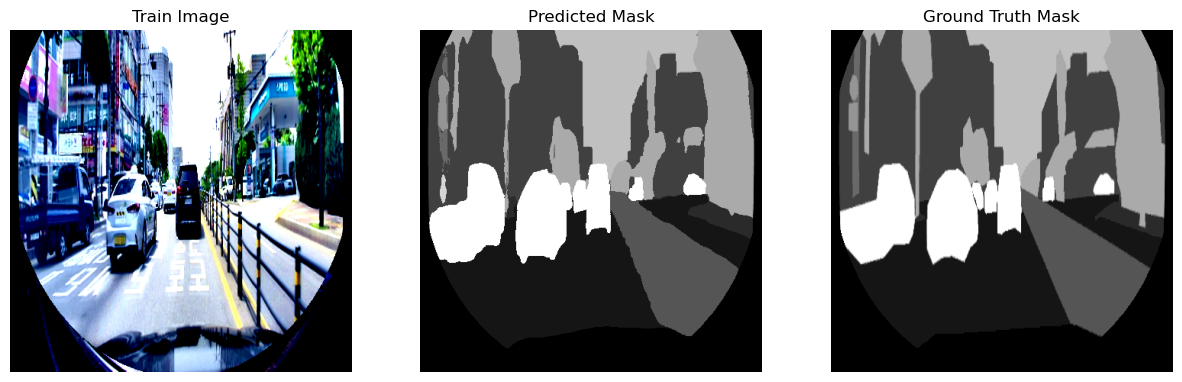

Hyperparamerters
LR = 0.001 | EP = 20, BATCH_SIZE = 4, N_CLASSES = 13, init_alpha = 0.001, N_LABELS = 3


In [19]:

# 시각화를 위한 코드
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 원본 이미지 시각화
aaa=source_image[0].permute(1, 2, 0).cpu().numpy()
a_source = aaa[:,:,0]
axes[0].imshow(aaa, cmap='gray')
#axes[0].imshow(np.transpose(source_image[0].cpu().numpy(), (1, 2, 0)))
axes[0].set_title('Train Image')
axes[0].axis('off')

# 예측 결과 시각화
# pred_mask = torch.softmax(source_outputs[0], dim=1).cpu().numpy()
# pred_mask = torch.argmax(pred_mask, dim=1).cpu().numpy()
axes[1].imshow(source_outputs[0], cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

# 실제 마스크 시각화
axes[2].imshow(source_mask[0].cpu().numpy(), cmap='gray')
axes[2].set_title('Ground Truth Mask')
axes[2].axis('off')

plt.show()

print("Hyperparamerters")
print(f"LR = {LR} | EP = {EP}, BATCH_SIZE = {BATCH_SIZE}, N_CLASSES = {N_CLASSES}, init_alpha = {ALPHA}, N_LABELS = {N_LABELS}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


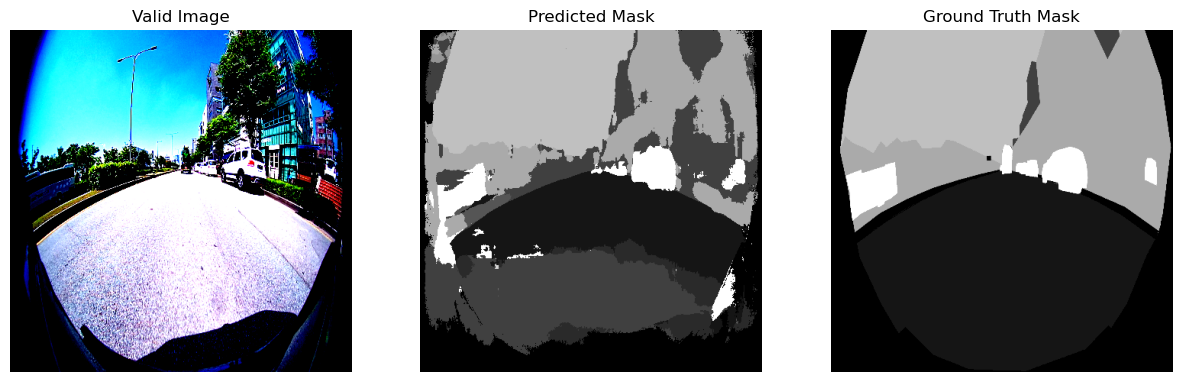

In [20]:
# 시각화를 위한 코드
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 원본 이미지 시각화
aaa=target_images[0].permute(1, 2, 0).cpu().numpy()
axes[0].imshow(aaa, cmap='gray')
#axes[0].imshow(np.transpose(source_image[0].cpu().numpy(), (1, 2, 0)))
axes[0].set_title('Valid Image')
axes[0].axis('off')

# 예측 결과 시각화
# pred_mask = torch.softmax(source_outputs[0], dim=1).cpu().numpy()
# pred_mask = torch.argmax(pred_mask, dim=1).cpu().numpy()
axes[1].imshow(target_outputs[0], cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

# 실제 마스크 시각화
axes[2].imshow(target_masks[0].cpu().numpy(), cmap='gray')
axes[2].set_title('Ground Truth Mask')
axes[2].axis('off')

plt.show()


In [21]:
# torch.save(model.state_dict(), './data/1122_unet_road2.pth')

## Real Fish-Eye Image Test

In [22]:
model = Unet(n_classes=13).to(device)
model.load_state_dict(torch.load('./data/1125_unet_1conv_448_crop48.pth'), strict=False)


val_target_dataset = CustomDataset(csv_file='./data/896_csv/val_source_CL_test_front.csv', transform=totensor, CL=1)
val_target_dataloader = DataLoader(val_target_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 클래스별 IoU를 누적할 리스트 초기화
val_class_ious = []
fish_val_class_ious = []
val_epoch_loss = 0
val_seg_loss = 0
val_domain_loss = 0
# valid
with torch.no_grad():
    model.eval()

    for target_images, target_masks in tqdm(val_target_dataloader):
        label = 5
        target_images, target_masks = apply_fisheye_distortion(target_images, target_masks, label)
        target_images = target_images.float().to(device)
        target_masks = target_masks.long().to(device)

        target_outputs = model(target_images)

        target_loss, target_seg_loss, target_domain_loss = loss_fn(target_outputs, target_masks, 1.5, alpha = ALPHA)

        val_seg_loss +=  target_seg_loss.item()
        val_domain_loss += target_domain_loss.item()
        
        loss = target_loss

        val_epoch_loss += loss.item()

        # train 클래스별 IoU 계산
        target_outputs = torch.softmax(target_outputs[0], dim=1).cpu()
        target_outputs = torch.argmax(target_outputs, dim=1).numpy()
        # target_masks -= 1
        for class_id in range(N_CLASSES):
            iou = calculate_iou_per_class(np.array(target_masks.cpu()), np.array(target_outputs), class_id)
            fish_val_class_ious.append(iou)

fish_val_class_ious = np.array(fish_val_class_ious).reshape(-1, N_CLASSES)
fish_val_class_ious = np.mean(fish_val_class_ious, axis=0)
print()
print("--IoU Scores Fish test--")
for class_id, iou in enumerate(fish_val_class_ious):
    print(f'Class{class_id:02d}: {iou:.4f}', end=" ")
    if (class_id+1) % 7 == 0:
        print()

# mIoU 계산
fish_val_mIoU = np.mean(fish_val_class_ious)
print()
print(f"Test Seg Loss: {(val_seg_loss/len(val_target_dataloader))}",f"Test dom Loss: {(val_domain_loss/len(val_target_dataloader))}")
print(f"Test Loss: {(val_epoch_loss/len(val_target_dataloader))}")
print(f"Test mIoU: {fish_val_mIoU}" )


  0%|          | 0/60 [00:00<?, ?it/s]/tmp/ipykernel_1217517/288732703.py:26: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  domain_target = torch.LongTensor([domain_num] * batch_size).to(device)
100%|██████████| 60/60 [00:27<00:00,  2.16it/s]


--IoU Scores Fish test--
Class00: 0.5471 Class01: 0.6621 Class02: 0.0159 Class03: 0.3406 Class04: 0.0322 Class05: 0.0099 Class06: 0.0108 
Class07: 0.0030 Class08: 0.5259 Class09: 0.8088 Class10: 0.0053 Class11: 0.0030 Class12: 0.2444 
Test Seg Loss: 1.4717752397060395 Test dom Loss: 0.4934018927315871
Test Loss: 1.4722686429818472
Test mIoU: 0.2468465197147056


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


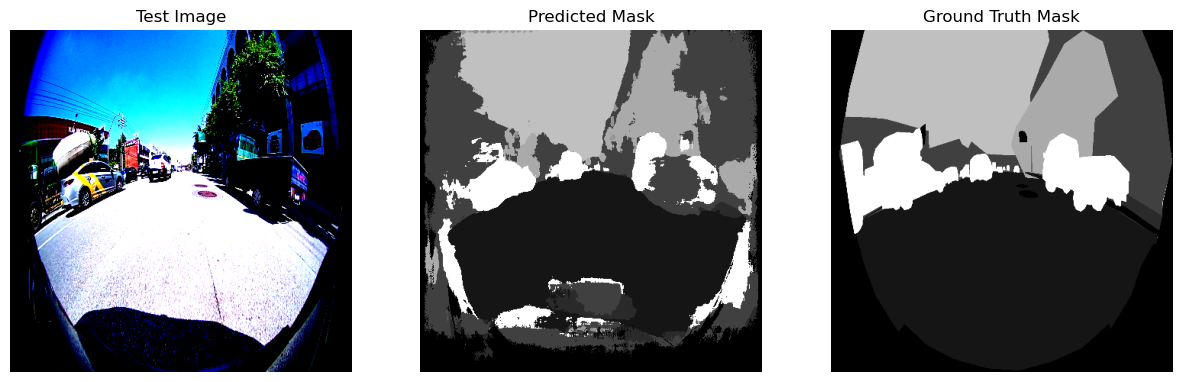

In [23]:
import matplotlib.pyplot as plt

# 시각화를 위한 코드
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 원본 이미지 시각화
aaa=target_images[0].permute(1, 2, 0).cpu().numpy()
a_fisheye = aaa[:,:,0]
axes[0].imshow(aaa, cmap='gray')
#axes[0].imshow(np.transpose(source_image[0].cpu().numpy(), (1, 2, 0)))
axes[0].set_title('Test Image')
axes[0].axis('off')

# 예측 결과 시각화
# pred_mask = torch.softmax(source_outputs[0], dim=1).cpu().numpy()
# pred_mask = torch.argmax(pred_mask, dim=1).cpu().numpy()
axes[1].imshow(target_outputs[0], cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

# 실제 마스크 시각화
axes[2].imshow(target_masks[0].cpu().numpy(), cmap='gray')
axes[2].set_title('Ground Truth Mask')
axes[2].axis('off')

plt.show()
